In [ ]:
import pandas as pd

In [ ]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

**Add Bloomberg ref info to create ticker lookup table**

In [ ]:
tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

from os import listdir
from os.path import isfile, join

mypath = 'Stocks/'

tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 


In [ ]:
for i in range(len(tickers)):
    raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
    year = raw_data.iloc[-1]['Date'][:4]
    n_datapoints = len(raw_data)
    tickers.loc[i,'year_last'] = year
    tickers.loc[i,'n_datapoints'] = n_datapoints

In [ ]:
tickers['year_last'] = tickers['year_last'].astype(int)

In [ ]:
tickers = tickers[~tickers['file_name'].str.contains('_')]
tickers = tickers[~tickers['file_name'].str.contains('-')]

In [ ]:
import pdblp

con = pdblp.BCon(debug=True, port=8194, timeout=5000)

tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

con.start()

ref_data = pd.DataFrame()

for ticker in tickers_['ticker'].tolist():
    try:
        ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
    except:
        True

In [ ]:
ref_data_copy = ref_data

In [ ]:
ref_data.pivot(index='ticker',columns='field',values='value')

In [ ]:
tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]

In [ ]:
tickers.head()

In [ ]:
tickers.to_csv('tickers_lookup.csv',index=False)

**Feature extraction**

In [ ]:
def create_features(ticker,trading_window=5,keep_sample=False):
    #Function to calculate useful statistics from raw data
    #Trading window in working days
    
    import numpy as np
    
    raw_data = pd.read_csv('Stocks/' + ticker + '.txt')
    raw_data.set_index('Date',inplace = True)
    
    features = pd.DataFrame(index=raw_data.index)
    
    features['Open'] = raw_data['Open']
    
    #Close std
    features['std_21_d'] = raw_data['Close'].shift(1).rolling(21).std()
    features['std_tw'] = raw_data['Close'].shift(1).rolling(trading_window).std()
    features['std_4tw'] = raw_data['Close'].shift(1).rolling(4*trading_window).std()
    
    #Overnight pct (Open_t - Close_t-1)
    features['pct_overnight'] = raw_data['Open'].div(raw_data['Close'].shift(1)) - 1
    
    #Close pct (Close - Close) & Close - Close std
    features['pct_close'] = raw_data['Close'].shift(1).div(raw_data['Close'].shift(2)) - 1
    features['pct_close_sigma_21'] = features['pct_close'].div(features['pct_close'].rolling(21).std())
    features['pct_close_sigma_tw'] = features['pct_close'].div(features['pct_close'].rolling(trading_window).std())
    features['pct_close_sigma_4tw'] = features['pct_close'].div(features['pct_close'].rolling(4*trading_window).std())
    
    #Average close return (Momentum)
    features['avg_return_21'] = features['pct_close'].rolling(21).mean()
    features['avg_return_tw'] = features['pct_close'].rolling(trading_window).mean()
    features['avg_return_4tw'] = features['pct_close'].rolling(4*trading_window).mean()
    
    #Open percentile
    def rank(array):
        s = pd.Series(array)
        return s.rank(ascending=True,pct=True)[len(s)-1]
    features['perctentile_tw'] = features['Open'].rolling(trading_window).apply(rank,raw=False)
    features['perctentile_4tw'] = features['Open'].rolling(4*trading_window).apply(rank,raw=False)
    
    #Volume
    features['pct_volume'] = raw_data['Volume'].shift(1).div(raw_data['Volume'].shift(2)) - 1
    features['pct_volume_sigma_21'] = features['pct_volume'].div(features['pct_volume'].rolling(21).std())
    features['pct_volume_sigma_tw'] = features['pct_volume'].div(features['pct_volume'].rolling(trading_window).std())
    features['pct_volume_sigma_4tw'] = features['pct_volume'].div(features['pct_volume'].rolling(4*trading_window).std())
    
    features.drop('pct_volume',axis=1,inplace = True)
    
    #Remove rows with na features
    features.dropna(inplace=True)
    
    #Keep random sample of size trading_window  
    if keep_sample:
        i = np.random.randint(0,high=len(features)-trading_window-1)
        features = features.iloc[i:i+trading_window,]
    
    prices= raw_data.loc[features.index,]
    
    return features, prices

In [ ]:
features, prices = create_features('baba.us',5,True)

**Reinforcement Learning**

In [1]:
import gym
import gym_market
import numpy as np

kwargs = {'pos_limit': 2,
                  'trading_window': 21,
                  'trading_freq': 1,
                  'ticker': 'ba.us'}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


C:\Users\Alex\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [2, 1, 0, 0, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1, 1]
Rewards: [1011.1768573307036, 977.646285338593, 1000.0, 1000.0, 1032.8083274292878, 1024.5906069286063, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 950.7875088560683, 986.0678577282412, 1016.6951347181667, 994.2541436464085, 1000.0, 987.7355335042926, 988.2840966421886, 1000.0, 975.1085224462878, 1003.1682507920625]
Return: 0.9466874445434152


In [3]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

***Training:***

Neural net architecture:

In [4]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [5]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [46]:
train_episodes = 10000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [47]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

Populate memory:

In [48]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [49]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: 21242.374392134163 Training loss: 1088918.0000 Explore P: 0.9979 Total return: 0.99
Episode: 2 Total reward: 20881.361590195 Training loss: 1020798.5000 Explore P: 0.9959 Total return: 0.88
Episode: 3 Total reward: 21204.929007553266 Training loss: 1005281.1250 Explore P: 0.9938 Total return: 1.21
Episode: 4 Total reward: 20865.011354515555 Training loss: 1007529.1875 Explore P: 0.9917 Total return: 0.85
Episode: 5 Total reward: 20940.391074964573 Training loss: 1044086.3750 Explore P: 0.9897 Total return: 0.91
Episode: 6 Total reward: 20935.220801538675 Training loss: 1010615.0000 Explore P: 0.9876 Total return: 0.92
Episode: 7 Total reward: 20882.148124420055 Training loss: 1058649.7500 Explore P: 0.9856 Total return: 0.85
Episode: 8 Total reward: 20909.274773261564 Training loss: 1032266.6875 Explore P: 0.9835 Total return: 0.91
Episode: 9 Total reward: 21142.189661908986 Training loss: 1001635.3750 Explore P: 0.9815 Total return: 1.04
Episode: 10 Total rewa

Episode: 77 Total reward: 20926.035637877583 Training loss: 3012357.2500 Explore P: 0.8522 Total return: 0.92
Episode: 78 Total reward: 20920.65549528582 Training loss: 1141940.3750 Explore P: 0.8504 Total return: 0.86
Episode: 79 Total reward: 20772.824858146174 Training loss: 1137433.0000 Explore P: 0.8487 Total return: 0.64
Episode: 80 Total reward: 21041.246269588006 Training loss: 1682330.2500 Explore P: 0.8469 Total return: 1.03
Episode: 81 Total reward: 20904.254089332666 Training loss: 1190802.0000 Explore P: 0.8451 Total return: 0.86
Episode: 82 Total reward: 20960.65772716253 Training loss: 1200143.3750 Explore P: 0.8434 Total return: 0.95
Episode: 83 Total reward: 20884.205088751387 Training loss: 1035235.6250 Explore P: 0.8416 Total return: 0.82
Episode: 84 Total reward: 20993.696963092927 Training loss: 1270214.0000 Explore P: 0.8399 Total return: 0.96
Episode: 85 Total reward: 21177.961880253246 Training loss: 1302807.8750 Explore P: 0.8382 Total return: 1.01
Episode: 86 

Episode: 151 Total reward: 21006.612138808352 Training loss: 3152168.5000 Explore P: 0.7310 Total return: 1.00
Episode: 152 Total reward: 20973.819568925697 Training loss: 31452134.0000 Explore P: 0.7295 Total return: 0.74
Episode: 153 Total reward: 21065.6123305468 Training loss: 19026996.0000 Explore P: 0.7280 Total return: 1.07
Episode: 154 Total reward: 21341.430575866754 Training loss: 7258136.0000 Explore P: 0.7264 Total return: 1.39
Episode: 155 Total reward: 20933.594080236075 Training loss: 2275254.5000 Explore P: 0.7249 Total return: 0.93
Episode: 156 Total reward: 21032.802150766423 Training loss: 2289957.2500 Explore P: 0.7234 Total return: 0.93
Episode: 157 Total reward: 21316.49301594306 Training loss: 9505114.0000 Explore P: 0.7219 Total return: 1.21
Episode: 158 Total reward: 21019.76621301763 Training loss: 3462202.0000 Explore P: 0.7205 Total return: 1.01
Episode: 159 Total reward: 21036.87918880767 Training loss: 6885260.0000 Explore P: 0.7190 Total return: 1.03
Epis

Episode: 227 Total reward: 20986.993758454537 Training loss: 1595286.3750 Explore P: 0.6246 Total return: 0.97
Episode: 228 Total reward: 20941.980834936818 Training loss: 1850189.6250 Explore P: 0.6233 Total return: 0.94
Episode: 229 Total reward: 20841.379459672375 Training loss: 3547597.2500 Explore P: 0.6220 Total return: 0.85
Episode: 230 Total reward: 20966.555706114534 Training loss: 4207152.0000 Explore P: 0.6208 Total return: 0.95
Episode: 231 Total reward: 21281.22314519099 Training loss: 2384693.5000 Explore P: 0.6195 Total return: 1.28
Episode: 232 Total reward: 21036.3727304482 Training loss: 7022060.0000 Explore P: 0.6182 Total return: 1.03
Episode: 233 Total reward: 21050.32279360598 Training loss: 2107511.0000 Explore P: 0.6169 Total return: 1.04
Episode: 234 Total reward: 21053.861607416966 Training loss: 1442901.7500 Explore P: 0.6157 Total return: 1.02
Episode: 235 Total reward: 20863.559123666153 Training loss: 26180068.0000 Explore P: 0.6144 Total return: 0.87
Epis

Episode: 303 Total reward: 20908.597432561022 Training loss: 2598294.5000 Explore P: 0.5340 Total return: 0.87
Episode: 304 Total reward: 21179.681140711356 Training loss: 141869408.0000 Explore P: 0.5329 Total return: 1.16
Episode: 305 Total reward: 21074.872798154945 Training loss: 2094285.2500 Explore P: 0.5318 Total return: 1.05
Episode: 306 Total reward: 21072.87774239295 Training loss: 24929612.0000 Explore P: 0.5307 Total return: 1.02
Episode: 307 Total reward: 21102.311629177635 Training loss: 293383744.0000 Explore P: 0.5296 Total return: 0.97
Episode: 308 Total reward: 20908.18672006653 Training loss: 7014447.0000 Explore P: 0.5285 Total return: 0.88
Episode: 309 Total reward: 21065.272521284012 Training loss: 11329034.0000 Explore P: 0.5274 Total return: 1.06
Episode: 310 Total reward: 21111.232280242242 Training loss: 1601504.1250 Explore P: 0.5263 Total return: 1.00
Episode: 311 Total reward: 21022.512319214973 Training loss: 7737841.5000 Explore P: 0.5252 Total return: 1.

Episode: 377 Total reward: 21169.77428987787 Training loss: 2528272.5000 Explore P: 0.4585 Total return: 0.90
Episode: 378 Total reward: 21007.669574138854 Training loss: 2156019.0000 Explore P: 0.4576 Total return: 0.96
Episode: 379 Total reward: 21178.491903859023 Training loss: 1469692.3750 Explore P: 0.4567 Total return: 1.04
Episode: 380 Total reward: 21026.694627771645 Training loss: 60913644.0000 Explore P: 0.4557 Total return: 0.82
Episode: 381 Total reward: 20968.14252147337 Training loss: 14462630.0000 Explore P: 0.4548 Total return: 0.83
Episode: 382 Total reward: 21052.884341320052 Training loss: 4422632.0000 Explore P: 0.4539 Total return: 0.91
Episode: 383 Total reward: 20931.109296751103 Training loss: 64433944.0000 Explore P: 0.4529 Total return: 0.93
Episode: 384 Total reward: 21059.06289129716 Training loss: 2984972.7500 Explore P: 0.4520 Total return: 1.05
Episode: 385 Total reward: 20980.997784193918 Training loss: 1861123.2500 Explore P: 0.4511 Total return: 0.98
E

Episode: 451 Total reward: 20973.044008619006 Training loss: 8813022.0000 Explore P: 0.3940 Total return: 0.97
Episode: 452 Total reward: 20920.993445910033 Training loss: 1560128.1250 Explore P: 0.3932 Total return: 0.92
Episode: 453 Total reward: 21120.408705418347 Training loss: 1482490.2500 Explore P: 0.3924 Total return: 1.12
Episode: 454 Total reward: 20801.7718296202 Training loss: 1773368.6250 Explore P: 0.3916 Total return: 0.81
Episode: 455 Total reward: 21120.482430734508 Training loss: 2493873.5000 Explore P: 0.3908 Total return: 1.09
Episode: 456 Total reward: 21184.829153034094 Training loss: 7345097.5000 Explore P: 0.3900 Total return: 1.19
Episode: 457 Total reward: 20941.534772356226 Training loss: 25660442.0000 Explore P: 0.3892 Total return: 0.94
Episode: 458 Total reward: 21015.470274617503 Training loss: 7674688.0000 Explore P: 0.3884 Total return: 1.01
Episode: 459 Total reward: 20866.17981468617 Training loss: 1486841.7500 Explore P: 0.3876 Total return: 0.87
Epi

Episode: 527 Total reward: 20841.494682335775 Training loss: 1775345.6250 Explore P: 0.3373 Total return: 0.79
Episode: 528 Total reward: 20868.36952979354 Training loss: 3848948.0000 Explore P: 0.3367 Total return: 0.87
Episode: 529 Total reward: 21077.857566514147 Training loss: 7144127.0000 Explore P: 0.3360 Total return: 1.08
Episode: 530 Total reward: 20987.63430248251 Training loss: 108618728.0000 Explore P: 0.3353 Total return: 0.99
Episode: 531 Total reward: 21138.301252234378 Training loss: 1500985.1250 Explore P: 0.3346 Total return: 1.13
Episode: 532 Total reward: 20981.186095622295 Training loss: 1429466.1250 Explore P: 0.3339 Total return: 0.98
Episode: 533 Total reward: 20745.523395013846 Training loss: 33838836.0000 Explore P: 0.3332 Total return: 0.70
Episode: 534 Total reward: 21048.487887783413 Training loss: 46128792.0000 Explore P: 0.3326 Total return: 1.05
Episode: 535 Total reward: 21045.06084965804 Training loss: 1977510.0000 Explore P: 0.3319 Total return: 1.04


Episode: 604 Total reward: 21054.06800751957 Training loss: 1676821.7500 Explore P: 0.2885 Total return: 1.06
Episode: 605 Total reward: 21035.54620217961 Training loss: 1646482.7500 Explore P: 0.2879 Total return: 1.03
Episode: 606 Total reward: 20956.674554764166 Training loss: 60937708.0000 Explore P: 0.2873 Total return: 0.94
Episode: 607 Total reward: 20944.785057269615 Training loss: 1234823.2500 Explore P: 0.2867 Total return: 0.94
Episode: 608 Total reward: 21057.857468817434 Training loss: 7294109.0000 Explore P: 0.2861 Total return: 1.05
Episode: 609 Total reward: 21117.33663305767 Training loss: 109162496.0000 Explore P: 0.2856 Total return: 1.12
Episode: 610 Total reward: 21027.10080366239 Training loss: 2621264.5000 Explore P: 0.2850 Total return: 1.02
Episode: 611 Total reward: 20862.681985452986 Training loss: 44104980.0000 Explore P: 0.2844 Total return: 0.84
Episode: 612 Total reward: 20733.735892459204 Training loss: 2103583.5000 Explore P: 0.2838 Total return: 0.75
E

Episode: 680 Total reward: 21245.38124409792 Training loss: 2109253.7500 Explore P: 0.2474 Total return: 1.23
Episode: 681 Total reward: 20879.622213999617 Training loss: 1791132.3750 Explore P: 0.2469 Total return: 0.88
Episode: 682 Total reward: 20503.19289657195 Training loss: 1740746.7500 Explore P: 0.2464 Total return: 0.56
Episode: 683 Total reward: 20963.554850022563 Training loss: 9619301.0000 Explore P: 0.2459 Total return: 0.96
Episode: 684 Total reward: 20886.607578413837 Training loss: 18903500.0000 Explore P: 0.2454 Total return: 0.76
Episode: 685 Total reward: 21078.650797205813 Training loss: 1530375.6250 Explore P: 0.2449 Total return: 1.08
Episode: 686 Total reward: 21000.0 Training loss: 1291941.7500 Explore P: 0.2444 Total return: 1.00
Episode: 687 Total reward: 21022.764251255565 Training loss: 1925330.3750 Explore P: 0.2439 Total return: 1.02
Episode: 688 Total reward: 21067.151684284174 Training loss: 8023731.0000 Explore P: 0.2434 Total return: 1.07
Episode: 689 

Episode: 755 Total reward: 20966.08630000954 Training loss: 2307410.5000 Explore P: 0.2128 Total return: 0.97
Episode: 756 Total reward: 21000.0 Training loss: 35395732.0000 Explore P: 0.2124 Total return: 1.00
Episode: 757 Total reward: 20891.30313635237 Training loss: 3842149.5000 Explore P: 0.2119 Total return: 0.87
Episode: 758 Total reward: 21000.0 Training loss: 7702330.5000 Explore P: 0.2115 Total return: 1.00
Episode: 759 Total reward: 20886.50254366372 Training loss: 1509452.5000 Explore P: 0.2111 Total return: 0.89
Episode: 760 Total reward: 20810.673512953894 Training loss: 1150758.3750 Explore P: 0.2107 Total return: 0.80
Episode: 761 Total reward: 21044.81490716703 Training loss: 1564816.2500 Explore P: 0.2103 Total return: 1.04
Episode: 762 Total reward: 20999.849511655666 Training loss: 71878872.0000 Explore P: 0.2098 Total return: 1.00
Episode: 763 Total reward: 20830.899436314474 Training loss: 1053158.7500 Explore P: 0.2094 Total return: 0.72
Episode: 764 Total reward

Episode: 831 Total reward: 20973.88776907365 Training loss: 3259075.5000 Explore P: 0.1829 Total return: 0.97
Episode: 832 Total reward: 21008.107540641206 Training loss: 84011888.0000 Explore P: 0.1825 Total return: 1.01
Episode: 833 Total reward: 21000.0 Training loss: 1392146.6250 Explore P: 0.1822 Total return: 1.00
Episode: 834 Total reward: 21218.37963986025 Training loss: 1781574.3750 Explore P: 0.1818 Total return: 1.23
Episode: 835 Total reward: 21058.027750210807 Training loss: 1363670.0000 Explore P: 0.1814 Total return: 1.06
Episode: 836 Total reward: 21064.863301732214 Training loss: 1297276.2500 Explore P: 0.1811 Total return: 1.05
Episode: 837 Total reward: 21065.725444736738 Training loss: 25568264.0000 Explore P: 0.1807 Total return: 1.07
Episode: 838 Total reward: 20927.79374885314 Training loss: 5775191.5000 Explore P: 0.1804 Total return: 0.93
Episode: 839 Total reward: 20961.71648949755 Training loss: 5384036.5000 Explore P: 0.1800 Total return: 0.96
Episode: 840 T

Episode: 909 Total reward: 20910.700034931637 Training loss: 6633796.0000 Explore P: 0.1568 Total return: 0.91
Episode: 910 Total reward: 21110.747383360136 Training loss: 24348352.0000 Explore P: 0.1565 Total return: 1.11
Episode: 911 Total reward: 20993.429347729572 Training loss: 15817365.0000 Explore P: 0.1561 Total return: 0.99
Episode: 912 Total reward: 21088.210284754136 Training loss: 1480805.7500 Explore P: 0.1558 Total return: 1.04
Episode: 913 Total reward: 20987.47421161214 Training loss: 20977010.0000 Explore P: 0.1555 Total return: 0.99
Episode: 914 Total reward: 20899.51383325057 Training loss: 1756951.7500 Explore P: 0.1552 Total return: 0.89
Episode: 915 Total reward: 21028.107899816227 Training loss: 3285657.2500 Explore P: 0.1549 Total return: 1.03
Episode: 916 Total reward: 20950.59964616567 Training loss: 136234256.0000 Explore P: 0.1546 Total return: 0.95
Episode: 917 Total reward: 20958.780461845763 Training loss: 72099984.0000 Explore P: 0.1543 Total return: 0.9

Episode: 985 Total reward: 21036.66413688263 Training loss: 1288939.1250 Explore P: 0.1351 Total return: 1.03
Episode: 986 Total reward: 21262.499895774174 Training loss: 1533294.6250 Explore P: 0.1348 Total return: 1.28
Episode: 987 Total reward: 20990.055405597384 Training loss: 1467235.3750 Explore P: 0.1346 Total return: 0.99
Episode: 988 Total reward: 21011.558980438647 Training loss: 1731506.3750 Explore P: 0.1343 Total return: 1.01
Episode: 989 Total reward: 21015.35960296068 Training loss: 3906192.7500 Explore P: 0.1341 Total return: 1.02
Episode: 990 Total reward: 21179.047274338736 Training loss: 1317831.6250 Explore P: 0.1338 Total return: 1.16
Episode: 991 Total reward: 20972.864832726904 Training loss: 6137141.0000 Explore P: 0.1335 Total return: 0.97
Episode: 992 Total reward: 21042.652055008773 Training loss: 1199415.8750 Explore P: 0.1333 Total return: 1.02
Episode: 993 Total reward: 21042.05875815002 Training loss: 1260421.8750 Explore P: 0.1330 Total return: 1.04
Epis

Episode: 1060 Total reward: 21027.5428371343 Training loss: 8931418.0000 Explore P: 0.1169 Total return: 1.01
Episode: 1061 Total reward: 20887.074156521227 Training loss: 2036256.6250 Explore P: 0.1167 Total return: 0.84
Episode: 1062 Total reward: 21000.0 Training loss: 6640931.0000 Explore P: 0.1164 Total return: 1.00
Episode: 1063 Total reward: 21000.0 Training loss: 2067707.3750 Explore P: 0.1162 Total return: 1.00
Episode: 1064 Total reward: 21017.172556058616 Training loss: 28629028.0000 Explore P: 0.1160 Total return: 1.02
Episode: 1065 Total reward: 21028.763388544954 Training loss: 870932.6250 Explore P: 0.1158 Total return: 1.01
Episode: 1066 Total reward: 20990.538641686184 Training loss: 1077781.3750 Explore P: 0.1155 Total return: 0.99
Episode: 1067 Total reward: 21000.0 Training loss: 25490536.0000 Explore P: 0.1153 Total return: 1.00
Episode: 1068 Total reward: 20982.083439644794 Training loss: 40926640.0000 Explore P: 0.1151 Total return: 0.98
Episode: 1069 Total rewar

Episode: 1135 Total reward: 21050.235970998707 Training loss: 20333294.0000 Explore P: 0.1013 Total return: 1.05
Episode: 1136 Total reward: 21000.0 Training loss: 957658.1875 Explore P: 0.1011 Total return: 1.00
Episode: 1137 Total reward: 20952.237374083466 Training loss: 1096877.8750 Explore P: 0.1009 Total return: 0.95
Episode: 1138 Total reward: 21239.247040669175 Training loss: 910612.3750 Explore P: 0.1007 Total return: 0.97
Episode: 1139 Total reward: 21069.155682525805 Training loss: 16293622.0000 Explore P: 0.1005 Total return: 1.05
Episode: 1140 Total reward: 21048.33471871768 Training loss: 6893250.5000 Explore P: 0.1004 Total return: 1.04
Episode: 1141 Total reward: 20914.145678966423 Training loss: 2226530.5000 Explore P: 0.1002 Total return: 0.92
Episode: 1142 Total reward: 20938.885323591843 Training loss: 19841350.0000 Explore P: 0.1000 Total return: 0.94
Episode: 1143 Total reward: 21008.9210058861 Training loss: 15992883.0000 Explore P: 0.0998 Total return: 1.01
Epis

Episode: 1211 Total reward: 21000.0 Training loss: 11771183.0000 Explore P: 0.0878 Total return: 1.00
Episode: 1212 Total reward: 20918.96817376033 Training loss: 2654747.5000 Explore P: 0.0877 Total return: 0.92
Episode: 1213 Total reward: 21000.0 Training loss: 960557.8125 Explore P: 0.0875 Total return: 1.00
Episode: 1214 Total reward: 21014.3199449172 Training loss: 1166049.2500 Explore P: 0.0873 Total return: 1.01
Episode: 1215 Total reward: 20987.166584966006 Training loss: 1040094.3750 Explore P: 0.0872 Total return: 0.98
Episode: 1216 Total reward: 20964.67648832601 Training loss: 1113402.6250 Explore P: 0.0870 Total return: 0.96
Episode: 1217 Total reward: 20960.934591708236 Training loss: 2158474.7500 Explore P: 0.0869 Total return: 0.96
Episode: 1218 Total reward: 20996.336443659275 Training loss: 15119446.0000 Explore P: 0.0867 Total return: 0.99
Episode: 1219 Total reward: 21000.0 Training loss: 5889606.5000 Explore P: 0.0865 Total return: 1.00
Episode: 1220 Total reward: 

Episode: 1286 Total reward: 21001.86316116344 Training loss: 13084416.0000 Explore P: 0.0765 Total return: 1.00
Episode: 1287 Total reward: 21110.698813335846 Training loss: 918895.8750 Explore P: 0.0764 Total return: 1.11
Episode: 1288 Total reward: 20905.425231283414 Training loss: 1150854.7500 Explore P: 0.0762 Total return: 0.91
Episode: 1289 Total reward: 20924.20127690592 Training loss: 1517261.2500 Explore P: 0.0761 Total return: 0.93
Episode: 1290 Total reward: 21076.12751097633 Training loss: 7618425.5000 Explore P: 0.0759 Total return: 1.08
Episode: 1291 Total reward: 21059.95015590318 Training loss: 1068925.3750 Explore P: 0.0758 Total return: 1.06
Episode: 1292 Total reward: 20959.170084880516 Training loss: 8688524.0000 Explore P: 0.0757 Total return: 0.94
Episode: 1293 Total reward: 21189.678662623177 Training loss: 2615613.5000 Explore P: 0.0755 Total return: 1.20
Episode: 1294 Total reward: 21055.156950856996 Training loss: 1315062.7500 Explore P: 0.0754 Total return: 1

Episode: 1363 Total reward: 21000.0 Training loss: 12041609.0000 Explore P: 0.0666 Total return: 1.00
Episode: 1364 Total reward: 20850.56657223796 Training loss: 19349028.0000 Explore P: 0.0664 Total return: 0.85
Episode: 1365 Total reward: 21000.0 Training loss: 10141174.0000 Explore P: 0.0663 Total return: 1.00
Episode: 1366 Total reward: 20979.891644092517 Training loss: 6968425.5000 Explore P: 0.0662 Total return: 0.98
Episode: 1367 Total reward: 21000.0 Training loss: 41013872.0000 Explore P: 0.0661 Total return: 1.00
Episode: 1368 Total reward: 21000.0 Training loss: 1594431.8750 Explore P: 0.0660 Total return: 1.00
Episode: 1369 Total reward: 21000.0 Training loss: 3327315.7500 Explore P: 0.0659 Total return: 1.00
Episode: 1370 Total reward: 21078.305047307 Training loss: 1002106.1875 Explore P: 0.0657 Total return: 1.08
Episode: 1371 Total reward: 20919.36887290446 Training loss: 3687406.0000 Explore P: 0.0656 Total return: 0.92
Episode: 1372 Total reward: 20894.004970658865 T

Episode: 1441 Total reward: 21000.0 Training loss: 2053488.6250 Explore P: 0.0580 Total return: 1.00
Episode: 1442 Total reward: 21039.91788381284 Training loss: 1799065.2500 Explore P: 0.0579 Total return: 1.04
Episode: 1443 Total reward: 21031.955606582473 Training loss: 2502922.5000 Explore P: 0.0578 Total return: 1.03
Episode: 1444 Total reward: 20892.76961065163 Training loss: 1881540.0000 Explore P: 0.0577 Total return: 0.90
Episode: 1445 Total reward: 21000.0 Training loss: 970095.3750 Explore P: 0.0576 Total return: 1.00
Episode: 1446 Total reward: 21211.71719747084 Training loss: 1758530.0000 Explore P: 0.0575 Total return: 1.22
Episode: 1447 Total reward: 20855.05295533149 Training loss: 12221328.0000 Explore P: 0.0574 Total return: 0.85
Episode: 1448 Total reward: 21129.37892533147 Training loss: 1813342.6250 Explore P: 0.0573 Total return: 1.13
Episode: 1449 Total reward: 21316.93164490294 Training loss: 2412758.0000 Explore P: 0.0572 Total return: 1.30
Episode: 1450 Total 

Episode: 1517 Total reward: 21097.464456300204 Training loss: 1411693.6250 Explore P: 0.0509 Total return: 1.10
Episode: 1518 Total reward: 21016.764839148163 Training loss: 1390239.7500 Explore P: 0.0508 Total return: 1.02
Episode: 1519 Total reward: 21164.48377604721 Training loss: 1017422.3750 Explore P: 0.0508 Total return: 1.17
Episode: 1520 Total reward: 21000.0 Training loss: 7662035.0000 Explore P: 0.0507 Total return: 1.00
Episode: 1521 Total reward: 21000.0 Training loss: 1479215.0000 Explore P: 0.0506 Total return: 1.00
Episode: 1522 Total reward: 20919.826366900175 Training loss: 188452512.0000 Explore P: 0.0505 Total return: 0.92
Episode: 1523 Total reward: 20987.13654425837 Training loss: 5098322.0000 Explore P: 0.0504 Total return: 0.99
Episode: 1524 Total reward: 20549.431370690327 Training loss: 56315496.0000 Explore P: 0.0503 Total return: 0.60
Episode: 1525 Total reward: 20835.246076951356 Training loss: 18634352.0000 Explore P: 0.0503 Total return: 0.82
Episode: 152

Episode: 1593 Total reward: 21024.273919323572 Training loss: 976488.1875 Explore P: 0.0449 Total return: 1.02
Episode: 1594 Total reward: 21014.442620074085 Training loss: 1122148.0000 Explore P: 0.0448 Total return: 1.01
Episode: 1595 Total reward: 20952.85975445238 Training loss: 998402.5000 Explore P: 0.0448 Total return: 0.95
Episode: 1596 Total reward: 21000.0 Training loss: 6065866.0000 Explore P: 0.0447 Total return: 1.00
Episode: 1597 Total reward: 21019.314356678322 Training loss: 1114285.6250 Explore P: 0.0446 Total return: 1.02
Episode: 1598 Total reward: 21000.0 Training loss: 883357.5000 Explore P: 0.0445 Total return: 1.00
Episode: 1599 Total reward: 21132.242764300998 Training loss: 964027.8125 Explore P: 0.0445 Total return: 1.13
Episode: 1600 Total reward: 21149.50385148818 Training loss: 2547141.5000 Explore P: 0.0444 Total return: 1.16
Episode: 1601 Total reward: 21000.0 Training loss: 1218019.0000 Explore P: 0.0443 Total return: 1.00
Episode: 1602 Total reward: 210

Episode: 1673 Total reward: 21000.0 Training loss: 13038638.0000 Explore P: 0.0395 Total return: 1.00
Episode: 1674 Total reward: 20980.889463796237 Training loss: 1148707.7500 Explore P: 0.0394 Total return: 0.98
Episode: 1675 Total reward: 21061.035579982643 Training loss: 1178578.8750 Explore P: 0.0394 Total return: 1.06
Episode: 1676 Total reward: 21101.423668112548 Training loss: 1289008.3750 Explore P: 0.0393 Total return: 1.10
Episode: 1677 Total reward: 20894.436066553917 Training loss: 1198850.6250 Explore P: 0.0393 Total return: 0.90
Episode: 1678 Total reward: 20865.312034841292 Training loss: 11931769.0000 Explore P: 0.0392 Total return: 0.87
Episode: 1679 Total reward: 21024.419948595725 Training loss: 2117174.7500 Explore P: 0.0391 Total return: 1.02
Episode: 1680 Total reward: 21178.26483115666 Training loss: 5653234.5000 Explore P: 0.0391 Total return: 1.19
Episode: 1681 Total reward: 21006.221029519395 Training loss: 1230150.7500 Explore P: 0.0390 Total return: 1.01
Ep

Episode: 1751 Total reward: 21000.0 Training loss: 1594782.7500 Explore P: 0.0350 Total return: 1.00
Episode: 1752 Total reward: 21000.0 Training loss: 1475306.8750 Explore P: 0.0350 Total return: 1.00
Episode: 1753 Total reward: 21000.0 Training loss: 8303427.0000 Explore P: 0.0349 Total return: 1.00
Episode: 1754 Total reward: 21000.0 Training loss: 1228535.2500 Explore P: 0.0349 Total return: 1.00
Episode: 1755 Total reward: 21000.0 Training loss: 1393368.5000 Explore P: 0.0348 Total return: 1.00
Episode: 1756 Total reward: 20903.229287319664 Training loss: 3397076.7500 Explore P: 0.0348 Total return: 0.90
Episode: 1757 Total reward: 21000.0 Training loss: 1893312.7500 Explore P: 0.0347 Total return: 1.00
Episode: 1758 Total reward: 21043.315550492924 Training loss: 1298783.3750 Explore P: 0.0347 Total return: 1.04
Episode: 1759 Total reward: 20905.862366519254 Training loss: 2197894.5000 Explore P: 0.0346 Total return: 0.91
Episode: 1760 Total reward: 21000.0 Training loss: 1448237

Episode: 1832 Total reward: 21000.0 Training loss: 7739481.5000 Explore P: 0.0311 Total return: 1.00
Episode: 1833 Total reward: 21000.0 Training loss: 2378624.0000 Explore P: 0.0311 Total return: 1.00
Episode: 1834 Total reward: 21000.0 Training loss: 9342148.0000 Explore P: 0.0310 Total return: 1.00
Episode: 1835 Total reward: 21000.0 Training loss: 2083802.7500 Explore P: 0.0310 Total return: 1.00
Episode: 1836 Total reward: 21000.0 Training loss: 31698266.0000 Explore P: 0.0309 Total return: 1.00
Episode: 1837 Total reward: 21000.0 Training loss: 916815.1250 Explore P: 0.0309 Total return: 1.00
Episode: 1838 Total reward: 21000.0 Training loss: 982372.6875 Explore P: 0.0309 Total return: 1.00
Episode: 1839 Total reward: 21000.0 Training loss: 1059399.3750 Explore P: 0.0308 Total return: 1.00
Episode: 1840 Total reward: 21000.0 Training loss: 139005808.0000 Explore P: 0.0308 Total return: 1.00
Episode: 1841 Total reward: 21000.0 Training loss: 9924150.0000 Explore P: 0.0307 Total re

Episode: 1914 Total reward: 20944.717189103623 Training loss: 5879054.5000 Explore P: 0.0278 Total return: 0.94
Episode: 1915 Total reward: 21000.0 Training loss: 4254760.0000 Explore P: 0.0277 Total return: 1.00
Episode: 1916 Total reward: 21026.727819073225 Training loss: 1353922.6250 Explore P: 0.0277 Total return: 1.03
Episode: 1917 Total reward: 21006.358541305384 Training loss: 1067416.0000 Explore P: 0.0277 Total return: 1.01
Episode: 1918 Total reward: 21002.74754875552 Training loss: 16392317.0000 Explore P: 0.0276 Total return: 1.00
Episode: 1919 Total reward: 21113.99506781751 Training loss: 1544530.6250 Explore P: 0.0276 Total return: 1.11
Episode: 1920 Total reward: 20992.208901957827 Training loss: 12332409.0000 Explore P: 0.0276 Total return: 0.99
Episode: 1921 Total reward: 20914.8315736551 Training loss: 1285728.2500 Explore P: 0.0275 Total return: 0.91
Episode: 1922 Total reward: 21000.0 Training loss: 1245144.2500 Explore P: 0.0275 Total return: 1.00
Episode: 1923 To

Episode: 1992 Total reward: 21000.0 Training loss: 32392188.0000 Explore P: 0.0251 Total return: 1.00
Episode: 1993 Total reward: 21000.0 Training loss: 1039557.8125 Explore P: 0.0251 Total return: 1.00
Episode: 1994 Total reward: 21000.0 Training loss: 3709166.0000 Explore P: 0.0250 Total return: 1.00
Episode: 1995 Total reward: 21000.0 Training loss: 1108081.2500 Explore P: 0.0250 Total return: 1.00
Episode: 1996 Total reward: 21000.0 Training loss: 1059092.7500 Explore P: 0.0250 Total return: 1.00
Episode: 1997 Total reward: 21000.0 Training loss: 4037650.5000 Explore P: 0.0249 Total return: 1.00
Episode: 1998 Total reward: 21000.0 Training loss: 992527.8125 Explore P: 0.0249 Total return: 1.00
Episode: 1999 Total reward: 21034.9109495023 Training loss: 4667832.5000 Explore P: 0.0249 Total return: 1.03
Episode: 2000 Total reward: 21000.0 Training loss: 1584269.1250 Explore P: 0.0248 Total return: 1.00
Episode: 2001 Total reward: 21000.0 Training loss: 231903520.0000 Explore P: 0.024

Episode: 2073 Total reward: 21000.0 Training loss: 1117256.2500 Explore P: 0.0227 Total return: 1.00
Episode: 2074 Total reward: 21000.0 Training loss: 988287.3750 Explore P: 0.0227 Total return: 1.00
Episode: 2075 Total reward: 21000.0 Training loss: 814034.0000 Explore P: 0.0227 Total return: 1.00
Episode: 2076 Total reward: 20970.328486806677 Training loss: 976569.8125 Explore P: 0.0227 Total return: 0.97
Episode: 2077 Total reward: 21000.0 Training loss: 1116444.1250 Explore P: 0.0226 Total return: 1.00
Episode: 2078 Total reward: 21000.0 Training loss: 1386367.0000 Explore P: 0.0226 Total return: 1.00
Episode: 2079 Total reward: 21000.0 Training loss: 5582813.0000 Explore P: 0.0226 Total return: 1.00
Episode: 2080 Total reward: 21000.0 Training loss: 2180935.0000 Explore P: 0.0225 Total return: 1.00
Episode: 2081 Total reward: 20999.0354118301 Training loss: 721922.0625 Explore P: 0.0225 Total return: 1.00
Episode: 2082 Total reward: 21088.777405138724 Training loss: 903274.1250 E

Episode: 2154 Total reward: 21000.0 Training loss: 951638.1250 Explore P: 0.0207 Total return: 1.00
Episode: 2155 Total reward: 21000.0 Training loss: 4136906.7500 Explore P: 0.0207 Total return: 1.00
Episode: 2156 Total reward: 21000.0 Training loss: 952169.8750 Explore P: 0.0207 Total return: 1.00
Episode: 2157 Total reward: 21000.0 Training loss: 8191786.5000 Explore P: 0.0207 Total return: 1.00
Episode: 2158 Total reward: 21000.0 Training loss: 1570105.7500 Explore P: 0.0207 Total return: 1.00
Episode: 2159 Total reward: 21000.0 Training loss: 1875524.3750 Explore P: 0.0206 Total return: 1.00
Episode: 2160 Total reward: 21000.0 Training loss: 1536139.5000 Explore P: 0.0206 Total return: 1.00
Episode: 2161 Total reward: 21000.0 Training loss: 1181341.6250 Explore P: 0.0206 Total return: 1.00
Episode: 2162 Total reward: 21000.0 Training loss: 780510.8750 Explore P: 0.0206 Total return: 1.00
Episode: 2163 Total reward: 21000.0 Training loss: 1006136.1250 Explore P: 0.0205 Total return

Episode: 2234 Total reward: 21015.114160145782 Training loss: 939877.3125 Explore P: 0.0191 Total return: 1.02
Episode: 2235 Total reward: 21000.0 Training loss: 1346443.2500 Explore P: 0.0191 Total return: 1.00
Episode: 2236 Total reward: 20991.57227977884 Training loss: 1170948.3750 Explore P: 0.0190 Total return: 0.99
Episode: 2237 Total reward: 21000.0 Training loss: 1113877.0000 Explore P: 0.0190 Total return: 1.00
Episode: 2238 Total reward: 21000.0 Training loss: 1437934.0000 Explore P: 0.0190 Total return: 1.00
Episode: 2239 Total reward: 21000.0 Training loss: 613638.3125 Explore P: 0.0190 Total return: 1.00
Episode: 2240 Total reward: 21000.0 Training loss: 1210070.2500 Explore P: 0.0190 Total return: 1.00
Episode: 2241 Total reward: 21000.0 Training loss: 1163618.8750 Explore P: 0.0189 Total return: 1.00
Episode: 2242 Total reward: 21000.0 Training loss: 1127622.0000 Explore P: 0.0189 Total return: 1.00
Episode: 2243 Total reward: 21000.0 Training loss: 11992006.0000 Explore

Episode: 2314 Total reward: 21000.0 Training loss: 154346960.0000 Explore P: 0.0177 Total return: 1.00
Episode: 2315 Total reward: 21000.0 Training loss: 782298.7500 Explore P: 0.0177 Total return: 1.00
Episode: 2316 Total reward: 21000.0 Training loss: 992261.6875 Explore P: 0.0176 Total return: 1.00
Episode: 2317 Total reward: 21000.0 Training loss: 7311269.0000 Explore P: 0.0176 Total return: 1.00
Episode: 2318 Total reward: 21000.0 Training loss: 16247077.0000 Explore P: 0.0176 Total return: 1.00
Episode: 2319 Total reward: 20945.848375451264 Training loss: 6144462.0000 Explore P: 0.0176 Total return: 0.95
Episode: 2320 Total reward: 21000.0 Training loss: 2698199.7500 Explore P: 0.0176 Total return: 1.00
Episode: 2321 Total reward: 21000.0 Training loss: 10361437.0000 Explore P: 0.0176 Total return: 1.00
Episode: 2322 Total reward: 21000.0 Training loss: 4769940.5000 Explore P: 0.0175 Total return: 1.00
Episode: 2323 Total reward: 20983.279622623886 Training loss: 680009.3750 Expl

Episode: 2396 Total reward: 21000.0 Training loss: 3050093.5000 Explore P: 0.0165 Total return: 1.00
Episode: 2397 Total reward: 21000.0 Training loss: 15426163.0000 Explore P: 0.0164 Total return: 1.00
Episode: 2398 Total reward: 21000.0 Training loss: 854610.6250 Explore P: 0.0164 Total return: 1.00
Episode: 2399 Total reward: 21000.0 Training loss: 2167150.5000 Explore P: 0.0164 Total return: 1.00
Episode: 2400 Total reward: 21000.0 Training loss: 1149320.3750 Explore P: 0.0164 Total return: 1.00
Episode: 2401 Total reward: 21000.0 Training loss: 6573863.0000 Explore P: 0.0164 Total return: 1.00
Episode: 2402 Total reward: 21000.0 Training loss: 10168035.0000 Explore P: 0.0164 Total return: 1.00
Episode: 2403 Total reward: 21000.0 Training loss: 3527421.2500 Explore P: 0.0164 Total return: 1.00
Episode: 2404 Total reward: 21051.531374761464 Training loss: 1182391.8750 Explore P: 0.0164 Total return: 1.05
Episode: 2405 Total reward: 21000.0 Training loss: 6787347.0000 Explore P: 0.01

Episode: 2477 Total reward: 21000.0 Training loss: 1214052.2500 Explore P: 0.0155 Total return: 1.00
Episode: 2478 Total reward: 21000.0 Training loss: 1277714.2500 Explore P: 0.0154 Total return: 1.00
Episode: 2479 Total reward: 20886.120155869743 Training loss: 6551155.0000 Explore P: 0.0154 Total return: 0.89
Episode: 2480 Total reward: 20968.645965740572 Training loss: 10502398.0000 Explore P: 0.0154 Total return: 0.97
Episode: 2481 Total reward: 20992.394404454706 Training loss: 1504374.7500 Explore P: 0.0154 Total return: 0.99
Episode: 2482 Total reward: 21000.0 Training loss: 16151885.0000 Explore P: 0.0154 Total return: 1.00
Episode: 2483 Total reward: 21000.0 Training loss: 3019330.0000 Explore P: 0.0154 Total return: 1.00
Episode: 2484 Total reward: 21000.0 Training loss: 6244900.5000 Explore P: 0.0154 Total return: 1.00
Episode: 2485 Total reward: 21000.0 Training loss: 11293680.0000 Explore P: 0.0154 Total return: 1.00
Episode: 2486 Total reward: 21000.0 Training loss: 8710

Episode: 2557 Total reward: 21000.0 Training loss: 2783229.5000 Explore P: 0.0146 Total return: 1.00
Episode: 2558 Total reward: 20956.62511144828 Training loss: 1299828.3750 Explore P: 0.0146 Total return: 0.96
Episode: 2559 Total reward: 21000.0 Training loss: 38025212.0000 Explore P: 0.0146 Total return: 1.00
Episode: 2560 Total reward: 21000.0 Training loss: 998390.3750 Explore P: 0.0146 Total return: 1.00
Episode: 2561 Total reward: 21000.0 Training loss: 1333401.3750 Explore P: 0.0146 Total return: 1.00
Episode: 2562 Total reward: 21000.0 Training loss: 2204767.5000 Explore P: 0.0146 Total return: 1.00
Episode: 2563 Total reward: 21000.0 Training loss: 9880327.0000 Explore P: 0.0146 Total return: 1.00
Episode: 2564 Total reward: 21000.0 Training loss: 2332675.5000 Explore P: 0.0145 Total return: 1.00
Episode: 2565 Total reward: 21000.0 Training loss: 1024005.1875 Explore P: 0.0145 Total return: 1.00
Episode: 2566 Total reward: 21000.0 Training loss: 4012058.5000 Explore P: 0.0145

Episode: 2639 Total reward: 21017.33935778717 Training loss: 763155.9375 Explore P: 0.0139 Total return: 1.02
Episode: 2640 Total reward: 20975.010087424344 Training loss: 1714526.7500 Explore P: 0.0139 Total return: 0.98
Episode: 2641 Total reward: 21000.0 Training loss: 1169583.1250 Explore P: 0.0139 Total return: 1.00
Episode: 2642 Total reward: 21071.76757655387 Training loss: 3340518.2500 Explore P: 0.0139 Total return: 1.07
Episode: 2643 Total reward: 21000.0 Training loss: 48452036.0000 Explore P: 0.0138 Total return: 1.00
Episode: 2644 Total reward: 21000.0 Training loss: 2597480.7500 Explore P: 0.0138 Total return: 1.00
Episode: 2645 Total reward: 21000.0 Training loss: 2363499.2500 Explore P: 0.0138 Total return: 1.00
Episode: 2646 Total reward: 21000.0 Training loss: 46203924.0000 Explore P: 0.0138 Total return: 1.00
Episode: 2647 Total reward: 21000.0 Training loss: 1023800.8750 Explore P: 0.0138 Total return: 1.00
Episode: 2648 Total reward: 21000.0 Training loss: 2170064.

Episode: 2721 Total reward: 21000.0 Training loss: 1188220.7500 Explore P: 0.0133 Total return: 1.00
Episode: 2722 Total reward: 21000.0 Training loss: 1248489.8750 Explore P: 0.0133 Total return: 1.00
Episode: 2723 Total reward: 20959.829195002374 Training loss: 1214858.0000 Explore P: 0.0133 Total return: 0.96
Episode: 2724 Total reward: 21000.0 Training loss: 957183.5000 Explore P: 0.0132 Total return: 1.00
Episode: 2725 Total reward: 21000.0 Training loss: 17765396.0000 Explore P: 0.0132 Total return: 1.00
Episode: 2726 Total reward: 21000.0 Training loss: 3312620.5000 Explore P: 0.0132 Total return: 1.00
Episode: 2727 Total reward: 21038.40891164019 Training loss: 7055582.5000 Explore P: 0.0132 Total return: 1.04
Episode: 2728 Total reward: 21000.0 Training loss: 3550856.5000 Explore P: 0.0132 Total return: 1.00
Episode: 2729 Total reward: 21000.0 Training loss: 12140122.0000 Explore P: 0.0132 Total return: 1.00
Episode: 2730 Total reward: 21000.0 Training loss: 1034370.1250 Explo

Episode: 2801 Total reward: 21000.0 Training loss: 1364777.2500 Explore P: 0.0128 Total return: 1.00
Episode: 2802 Total reward: 21000.0 Training loss: 889665.3125 Explore P: 0.0128 Total return: 1.00
Episode: 2803 Total reward: 21000.0 Training loss: 8066875.0000 Explore P: 0.0127 Total return: 1.00
Episode: 2804 Total reward: 21000.0 Training loss: 6538411.0000 Explore P: 0.0127 Total return: 1.00
Episode: 2805 Total reward: 21000.0 Training loss: 4754002.0000 Explore P: 0.0127 Total return: 1.00
Episode: 2806 Total reward: 21000.0 Training loss: 1012345.8125 Explore P: 0.0127 Total return: 1.00
Episode: 2807 Total reward: 21000.0 Training loss: 4561886.5000 Explore P: 0.0127 Total return: 1.00
Episode: 2808 Total reward: 21000.0 Training loss: 4434121.0000 Explore P: 0.0127 Total return: 1.00
Episode: 2809 Total reward: 21000.0 Training loss: 1021224.1250 Explore P: 0.0127 Total return: 1.00
Episode: 2810 Total reward: 21000.0 Training loss: 14320350.0000 Explore P: 0.0127 Total ret

Episode: 2883 Total reward: 21000.0 Training loss: 7804811.0000 Explore P: 0.0123 Total return: 1.00
Episode: 2884 Total reward: 21000.0 Training loss: 1070506.7500 Explore P: 0.0123 Total return: 1.00
Episode: 2885 Total reward: 21000.0 Training loss: 11142734.0000 Explore P: 0.0123 Total return: 1.00
Episode: 2886 Total reward: 21000.0 Training loss: 40527944.0000 Explore P: 0.0123 Total return: 1.00
Episode: 2887 Total reward: 21000.0 Training loss: 5569821.5000 Explore P: 0.0123 Total return: 1.00
Episode: 2888 Total reward: 21002.935250798942 Training loss: 9356238.0000 Explore P: 0.0123 Total return: 1.00
Episode: 2889 Total reward: 21000.0 Training loss: 10606332.0000 Explore P: 0.0123 Total return: 1.00
Episode: 2890 Total reward: 21000.0 Training loss: 23377316.0000 Explore P: 0.0123 Total return: 1.00
Episode: 2891 Total reward: 21000.0 Training loss: 2032245.2500 Explore P: 0.0123 Total return: 1.00
Episode: 2892 Total reward: 21000.0 Training loss: 10260389.0000 Explore P: 

Episode: 2964 Total reward: 21000.0 Training loss: 1003793.1875 Explore P: 0.0120 Total return: 1.00
Episode: 2965 Total reward: 21000.0 Training loss: 3000252.5000 Explore P: 0.0120 Total return: 1.00
Episode: 2966 Total reward: 21000.0 Training loss: 1382085.5000 Explore P: 0.0120 Total return: 1.00
Episode: 2967 Total reward: 21000.0 Training loss: 5844971.0000 Explore P: 0.0119 Total return: 1.00
Episode: 2968 Total reward: 21000.0 Training loss: 5459508.5000 Explore P: 0.0119 Total return: 1.00
Episode: 2969 Total reward: 21000.0 Training loss: 1541569.6250 Explore P: 0.0119 Total return: 1.00
Episode: 2970 Total reward: 21000.0 Training loss: 5046243.0000 Explore P: 0.0119 Total return: 1.00
Episode: 2971 Total reward: 21000.0 Training loss: 858824.1250 Explore P: 0.0119 Total return: 1.00
Episode: 2972 Total reward: 21000.0 Training loss: 34379416.0000 Explore P: 0.0119 Total return: 1.00
Episode: 2973 Total reward: 20963.54536748123 Training loss: 2077658.2500 Explore P: 0.0119

Episode: 3044 Total reward: 20908.8987620239 Training loss: 1617932.7500 Explore P: 0.0117 Total return: 0.91
Episode: 3045 Total reward: 21000.0 Training loss: 15290576.0000 Explore P: 0.0117 Total return: 1.00
Episode: 3046 Total reward: 21000.0 Training loss: 5276703.5000 Explore P: 0.0117 Total return: 1.00
Episode: 3047 Total reward: 21000.0 Training loss: 12579934.0000 Explore P: 0.0116 Total return: 1.00
Episode: 3048 Total reward: 21031.867975529945 Training loss: 3712886.7500 Explore P: 0.0116 Total return: 1.03
Episode: 3049 Total reward: 21000.0 Training loss: 5163647.0000 Explore P: 0.0116 Total return: 1.00
Episode: 3050 Total reward: 21000.0 Training loss: 2968573.0000 Explore P: 0.0116 Total return: 1.00
Episode: 3051 Total reward: 21042.833997164653 Training loss: 1227240.1250 Explore P: 0.0116 Total return: 1.04
Episode: 3052 Total reward: 21000.0 Training loss: 7982099.0000 Explore P: 0.0116 Total return: 1.00
Episode: 3053 Total reward: 21000.0 Training loss: 1007577

Episode: 3126 Total reward: 21000.0 Training loss: 7693557.0000 Explore P: 0.0114 Total return: 1.00
Episode: 3127 Total reward: 21021.240963519132 Training loss: 3215731.7500 Explore P: 0.0114 Total return: 1.02
Episode: 3128 Total reward: 21000.0 Training loss: 1265467.3750 Explore P: 0.0114 Total return: 1.00
Episode: 3129 Total reward: 21000.0 Training loss: 42777704.0000 Explore P: 0.0114 Total return: 1.00
Episode: 3130 Total reward: 21000.0 Training loss: 1111629.6250 Explore P: 0.0114 Total return: 1.00
Episode: 3131 Total reward: 21000.0 Training loss: 1178132.3750 Explore P: 0.0114 Total return: 1.00
Episode: 3132 Total reward: 21000.0 Training loss: 11103190.0000 Explore P: 0.0114 Total return: 1.00
Episode: 3133 Total reward: 21000.0 Training loss: 1049773.3750 Explore P: 0.0114 Total return: 1.00
Episode: 3134 Total reward: 20904.513030581256 Training loss: 3751667.2500 Explore P: 0.0114 Total return: 0.90
Episode: 3135 Total reward: 21000.0 Training loss: 19880248.0000 Ex

Episode: 3206 Total reward: 21000.0 Training loss: 20393592.0000 Explore P: 0.0112 Total return: 1.00
Episode: 3207 Total reward: 21000.0 Training loss: 1247066.3750 Explore P: 0.0112 Total return: 1.00
Episode: 3208 Total reward: 21000.0 Training loss: 708624.0625 Explore P: 0.0112 Total return: 1.00
Episode: 3209 Total reward: 21000.0 Training loss: 1624895.6250 Explore P: 0.0112 Total return: 1.00
Episode: 3210 Total reward: 21000.0 Training loss: 32067270.0000 Explore P: 0.0112 Total return: 1.00
Episode: 3211 Total reward: 21000.0 Training loss: 1332171.3750 Explore P: 0.0112 Total return: 1.00
Episode: 3212 Total reward: 21000.0 Training loss: 12784900.0000 Explore P: 0.0112 Total return: 1.00
Episode: 3213 Total reward: 21000.0 Training loss: 21247356.0000 Explore P: 0.0112 Total return: 1.00
Episode: 3214 Total reward: 21000.0 Training loss: 19109074.0000 Explore P: 0.0112 Total return: 1.00
Episode: 3215 Total reward: 21000.0 Training loss: 20563692.0000 Explore P: 0.0112 Tota

Episode: 3288 Total reward: 21000.0 Training loss: 9287796.0000 Explore P: 0.0110 Total return: 1.00
Episode: 3289 Total reward: 21018.412749777526 Training loss: 1496985.0000 Explore P: 0.0110 Total return: 1.02
Episode: 3290 Total reward: 21000.0 Training loss: 1926113.3750 Explore P: 0.0110 Total return: 1.00
Episode: 3291 Total reward: 21000.0 Training loss: 5231240.0000 Explore P: 0.0110 Total return: 1.00
Episode: 3292 Total reward: 21000.0 Training loss: 30474310.0000 Explore P: 0.0110 Total return: 1.00
Episode: 3293 Total reward: 21000.0 Training loss: 40597544.0000 Explore P: 0.0110 Total return: 1.00
Episode: 3294 Total reward: 20954.374190387454 Training loss: 15164317.0000 Explore P: 0.0110 Total return: 0.95
Episode: 3295 Total reward: 21000.0 Training loss: 8831484.0000 Explore P: 0.0110 Total return: 1.00
Episode: 3296 Total reward: 20994.324756184913 Training loss: 4991393.0000 Explore P: 0.0110 Total return: 0.99
Episode: 3297 Total reward: 20994.137740029542 Training

Episode: 3370 Total reward: 21000.0 Training loss: 6767327.0000 Explore P: 0.0108 Total return: 1.00
Episode: 3371 Total reward: 21000.0 Training loss: 3946490.5000 Explore P: 0.0108 Total return: 1.00
Episode: 3372 Total reward: 21075.984532792732 Training loss: 53652568.0000 Explore P: 0.0108 Total return: 1.08
Episode: 3373 Total reward: 21000.0 Training loss: 1479920.5000 Explore P: 0.0108 Total return: 1.00
Episode: 3374 Total reward: 21000.0 Training loss: 808177.1250 Explore P: 0.0108 Total return: 1.00
Episode: 3375 Total reward: 21000.0 Training loss: 1514864.0000 Explore P: 0.0108 Total return: 1.00
Episode: 3376 Total reward: 21000.0 Training loss: 46782784.0000 Explore P: 0.0108 Total return: 1.00
Episode: 3377 Total reward: 21000.0 Training loss: 3309667.7500 Explore P: 0.0108 Total return: 1.00
Episode: 3378 Total reward: 21000.0 Training loss: 6943371.0000 Explore P: 0.0108 Total return: 1.00
Episode: 3379 Total reward: 21048.152600097306 Training loss: 1266315.7500 Expl

Episode: 3451 Total reward: 21000.0 Training loss: 35363892.0000 Explore P: 0.0107 Total return: 1.00
Episode: 3452 Total reward: 21000.0 Training loss: 5116645.0000 Explore P: 0.0107 Total return: 1.00
Episode: 3453 Total reward: 21000.0 Training loss: 4618069.0000 Explore P: 0.0107 Total return: 1.00
Episode: 3454 Total reward: 21000.0 Training loss: 2159735.7500 Explore P: 0.0107 Total return: 1.00
Episode: 3455 Total reward: 21000.0 Training loss: 6666941.0000 Explore P: 0.0107 Total return: 1.00
Episode: 3456 Total reward: 21000.0 Training loss: 1674286.7500 Explore P: 0.0107 Total return: 1.00
Episode: 3457 Total reward: 21000.0 Training loss: 10083373.0000 Explore P: 0.0107 Total return: 1.00
Episode: 3458 Total reward: 21000.0 Training loss: 1428223.5000 Explore P: 0.0107 Total return: 1.00
Episode: 3459 Total reward: 21000.0 Training loss: 971442.6875 Explore P: 0.0107 Total return: 1.00
Episode: 3460 Total reward: 21000.0 Training loss: 4399423.0000 Explore P: 0.0107 Total re

Episode: 3533 Total reward: 21000.0 Training loss: 23468084.0000 Explore P: 0.0106 Total return: 1.00
Episode: 3534 Total reward: 21000.0 Training loss: 2457915.2500 Explore P: 0.0106 Total return: 1.00
Episode: 3535 Total reward: 21000.0 Training loss: 11928385.0000 Explore P: 0.0106 Total return: 1.00
Episode: 3536 Total reward: 21000.0 Training loss: 12496336.0000 Explore P: 0.0106 Total return: 1.00
Episode: 3537 Total reward: 21000.0 Training loss: 12984950.0000 Explore P: 0.0106 Total return: 1.00
Episode: 3538 Total reward: 21000.0 Training loss: 1833916.6250 Explore P: 0.0106 Total return: 1.00
Episode: 3539 Total reward: 21000.0 Training loss: 1357825.0000 Explore P: 0.0106 Total return: 1.00
Episode: 3540 Total reward: 21000.0 Training loss: 10862413.0000 Explore P: 0.0106 Total return: 1.00
Episode: 3541 Total reward: 21000.0 Training loss: 6296243.0000 Explore P: 0.0106 Total return: 1.00
Episode: 3542 Total reward: 21000.0 Training loss: 1545370.7500 Explore P: 0.0106 Tota

Episode: 3614 Total reward: 21000.0 Training loss: 58833640.0000 Explore P: 0.0105 Total return: 1.00
Episode: 3615 Total reward: 21000.0 Training loss: 7404305.0000 Explore P: 0.0105 Total return: 1.00
Episode: 3616 Total reward: 21000.0 Training loss: 18921764.0000 Explore P: 0.0105 Total return: 1.00
Episode: 3617 Total reward: 21000.0 Training loss: 907457.1250 Explore P: 0.0105 Total return: 1.00
Episode: 3618 Total reward: 21000.0 Training loss: 1180487.7500 Explore P: 0.0105 Total return: 1.00
Episode: 3619 Total reward: 21000.0 Training loss: 7303310.5000 Explore P: 0.0105 Total return: 1.00
Episode: 3620 Total reward: 21015.206528381925 Training loss: 10337450.0000 Explore P: 0.0105 Total return: 1.02
Episode: 3621 Total reward: 21000.0 Training loss: 1084673.6250 Explore P: 0.0105 Total return: 1.00
Episode: 3622 Total reward: 21000.0 Training loss: 12409578.0000 Explore P: 0.0105 Total return: 1.00
Episode: 3623 Total reward: 21000.0 Training loss: 4719669.0000 Explore P: 0.

Episode: 3694 Total reward: 21014.44539982803 Training loss: 23712170.0000 Explore P: 0.0104 Total return: 1.01
Episode: 3695 Total reward: 21000.0 Training loss: 20243664.0000 Explore P: 0.0104 Total return: 1.00
Episode: 3696 Total reward: 21000.0 Training loss: 6588127.0000 Explore P: 0.0104 Total return: 1.00
Episode: 3697 Total reward: 21000.0 Training loss: 39490464.0000 Explore P: 0.0104 Total return: 1.00
Episode: 3698 Total reward: 21000.0 Training loss: 16799434.0000 Explore P: 0.0104 Total return: 1.00
Episode: 3699 Total reward: 21000.0 Training loss: 24852440.0000 Explore P: 0.0104 Total return: 1.00
Episode: 3700 Total reward: 20875.043947029182 Training loss: 7740363.0000 Explore P: 0.0104 Total return: 0.88
Episode: 3701 Total reward: 21000.0 Training loss: 9239418.0000 Explore P: 0.0104 Total return: 1.00
Episode: 3702 Total reward: 21000.0 Training loss: 22497090.0000 Explore P: 0.0104 Total return: 1.00
Episode: 3703 Total reward: 21000.0 Training loss: 890058.0000 E

Episode: 3777 Total reward: 21000.0 Training loss: 1199455.6250 Explore P: 0.0104 Total return: 1.00
Episode: 3778 Total reward: 21000.0 Training loss: 17443592.0000 Explore P: 0.0104 Total return: 1.00
Episode: 3779 Total reward: 21000.0 Training loss: 1897850.7500 Explore P: 0.0104 Total return: 1.00
Episode: 3780 Total reward: 21000.0 Training loss: 933485.1250 Explore P: 0.0104 Total return: 1.00
Episode: 3781 Total reward: 21000.0 Training loss: 10094350.0000 Explore P: 0.0104 Total return: 1.00
Episode: 3782 Total reward: 21000.0 Training loss: 1042430.6250 Explore P: 0.0104 Total return: 1.00
Episode: 3783 Total reward: 21000.0 Training loss: 816617.1875 Explore P: 0.0104 Total return: 1.00
Episode: 3784 Total reward: 21000.0 Training loss: 2398501.2500 Explore P: 0.0104 Total return: 1.00
Episode: 3785 Total reward: 21000.0 Training loss: 10081873.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3786 Total reward: 21000.0 Training loss: 1524400.2500 Explore P: 0.0103 Total re

Episode: 3857 Total reward: 21000.0 Training loss: 25939630.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3858 Total reward: 21000.0 Training loss: 2247674.5000 Explore P: 0.0103 Total return: 1.00
Episode: 3859 Total reward: 21000.0 Training loss: 1956336.3750 Explore P: 0.0103 Total return: 1.00
Episode: 3860 Total reward: 21000.0 Training loss: 14495090.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3861 Total reward: 21000.0 Training loss: 18144244.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3862 Total reward: 21000.0 Training loss: 25134880.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3863 Total reward: 20993.198421361994 Training loss: 14527181.0000 Explore P: 0.0103 Total return: 0.99
Episode: 3864 Total reward: 21000.0 Training loss: 13750926.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3865 Total reward: 21000.0 Training loss: 17961044.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3866 Total reward: 21000.0 Training loss: 1062513.2500 Explore P

Episode: 3939 Total reward: 20976.70355270821 Training loss: 1700075.3750 Explore P: 0.0103 Total return: 0.98
Episode: 3940 Total reward: 21000.0 Training loss: 15442917.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3941 Total reward: 21000.0 Training loss: 12502598.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3942 Total reward: 21000.0 Training loss: 1927153.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3943 Total reward: 21000.0 Training loss: 12924707.0000 Explore P: 0.0103 Total return: 1.00
Episode: 3944 Total reward: 21000.0 Training loss: 2340107.5000 Explore P: 0.0103 Total return: 1.00
Episode: 3945 Total reward: 21000.0 Training loss: 20028836.0000 Explore P: 0.0102 Total return: 1.00
Episode: 3946 Total reward: 21000.0 Training loss: 2111357.5000 Explore P: 0.0102 Total return: 1.00
Episode: 3947 Total reward: 21000.0 Training loss: 3285377.5000 Explore P: 0.0102 Total return: 1.00
Episode: 3948 Total reward: 21000.0 Training loss: 1714986.3750 Explore P: 0.

Episode: 4020 Total reward: 21000.0 Training loss: 5899492.5000 Explore P: 0.0102 Total return: 1.00
Episode: 4021 Total reward: 21000.0 Training loss: 24729298.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4022 Total reward: 21105.870260392872 Training loss: 1577252.0000 Explore P: 0.0102 Total return: 1.11
Episode: 4023 Total reward: 21000.0 Training loss: 34089364.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4024 Total reward: 21000.0 Training loss: 1348426.6250 Explore P: 0.0102 Total return: 1.00
Episode: 4025 Total reward: 21000.0 Training loss: 7450997.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4026 Total reward: 21000.0 Training loss: 707594.5625 Explore P: 0.0102 Total return: 1.00
Episode: 4027 Total reward: 21000.0 Training loss: 11750927.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4028 Total reward: 21000.0 Training loss: 7128251.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4029 Total reward: 21000.0 Training loss: 6562009.0000 Explore P: 0.0

Episode: 4102 Total reward: 21000.0 Training loss: 12552018.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4103 Total reward: 21000.0 Training loss: 27708838.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4104 Total reward: 21000.0 Training loss: 675734.0625 Explore P: 0.0102 Total return: 1.00
Episode: 4105 Total reward: 20966.806017079358 Training loss: 1587768.0000 Explore P: 0.0102 Total return: 0.97
Episode: 4106 Total reward: 20994.77469087899 Training loss: 20239422.0000 Explore P: 0.0102 Total return: 0.99
Episode: 4107 Total reward: 21000.0 Training loss: 8612107.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4108 Total reward: 21000.0 Training loss: 2345614.5000 Explore P: 0.0102 Total return: 1.00
Episode: 4109 Total reward: 21000.0 Training loss: 17965310.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4110 Total reward: 21000.0 Training loss: 558749.1875 Explore P: 0.0102 Total return: 1.00
Episode: 4111 Total reward: 21000.0 Training loss: 1958596.0000 Expl

Episode: 4183 Total reward: 21000.0 Training loss: 32890100.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4184 Total reward: 21000.0 Training loss: 1755993.6250 Explore P: 0.0102 Total return: 1.00
Episode: 4185 Total reward: 21000.0 Training loss: 3575398.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4186 Total reward: 21000.0 Training loss: 1598599.1250 Explore P: 0.0102 Total return: 1.00
Episode: 4187 Total reward: 21000.0 Training loss: 2439995.5000 Explore P: 0.0102 Total return: 1.00
Episode: 4188 Total reward: 21000.0 Training loss: 5650701.0000 Explore P: 0.0102 Total return: 1.00
Episode: 4189 Total reward: 20873.047014339732 Training loss: 10043865.0000 Explore P: 0.0101 Total return: 0.87
Episode: 4190 Total reward: 21000.0 Training loss: 1533686.5000 Explore P: 0.0101 Total return: 1.00
Episode: 4191 Total reward: 21000.0 Training loss: 1329592.2500 Explore P: 0.0101 Total return: 1.00
Episode: 4192 Total reward: 21000.0 Training loss: 12547842.0000 Explore P: 0.

Episode: 4264 Total reward: 21000.0 Training loss: 2037713.2500 Explore P: 0.0101 Total return: 1.00
Episode: 4265 Total reward: 21000.0 Training loss: 19314172.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4266 Total reward: 21000.0 Training loss: 1166054.3750 Explore P: 0.0101 Total return: 1.00
Episode: 4267 Total reward: 21118.397011099296 Training loss: 824882.6250 Explore P: 0.0101 Total return: 1.12
Episode: 4268 Total reward: 21000.0 Training loss: 18716052.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4269 Total reward: 21000.0 Training loss: 2193887.5000 Explore P: 0.0101 Total return: 1.00
Episode: 4270 Total reward: 21000.0 Training loss: 37599176.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4271 Total reward: 21000.0 Training loss: 4866296.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4272 Total reward: 21000.0 Training loss: 1235930.6250 Explore P: 0.0101 Total return: 1.00
Episode: 4273 Total reward: 21000.0 Training loss: 7607373.0000 Explore P: 0.0

Episode: 4344 Total reward: 21000.0 Training loss: 1755232.6250 Explore P: 0.0101 Total return: 1.00
Episode: 4345 Total reward: 21000.0 Training loss: 48125300.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4346 Total reward: 20978.873772684823 Training loss: 2238730.5000 Explore P: 0.0101 Total return: 0.98
Episode: 4347 Total reward: 21000.0 Training loss: 19768632.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4348 Total reward: 21026.03203943315 Training loss: 14061779.0000 Explore P: 0.0101 Total return: 1.03
Episode: 4349 Total reward: 21000.0 Training loss: 1096461.5000 Explore P: 0.0101 Total return: 1.00
Episode: 4350 Total reward: 21000.0 Training loss: 2314093.2500 Explore P: 0.0101 Total return: 1.00
Episode: 4351 Total reward: 21000.0 Training loss: 1263333.6250 Explore P: 0.0101 Total return: 1.00
Episode: 4352 Total reward: 21000.0 Training loss: 18478766.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4353 Total reward: 21000.0 Training loss: 11596114.0000 E

Episode: 4425 Total reward: 21000.0 Training loss: 9868945.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4426 Total reward: 20791.91221156205 Training loss: 20337068.0000 Explore P: 0.0101 Total return: 0.80
Episode: 4427 Total reward: 21000.0 Training loss: 986088.8750 Explore P: 0.0101 Total return: 1.00
Episode: 4428 Total reward: 21000.0 Training loss: 7399376.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4429 Total reward: 21000.0 Training loss: 22207642.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4430 Total reward: 21000.0 Training loss: 26685918.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4431 Total reward: 21000.0 Training loss: 2596881.5000 Explore P: 0.0101 Total return: 1.00
Episode: 4432 Total reward: 21030.191300630544 Training loss: 19579612.0000 Explore P: 0.0101 Total return: 1.03
Episode: 4433 Total reward: 21000.0 Training loss: 18177780.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4434 Total reward: 20925.924987970724 Training loss: 2291

Episode: 4506 Total reward: 20810.055554303137 Training loss: 1918010.0000 Explore P: 0.0101 Total return: 0.82
Episode: 4507 Total reward: 21000.0 Training loss: 20464638.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4508 Total reward: 21000.0 Training loss: 21995030.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4509 Total reward: 21000.0 Training loss: 21853518.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4510 Total reward: 21000.0 Training loss: 1055106.8750 Explore P: 0.0101 Total return: 1.00
Episode: 4511 Total reward: 21000.0 Training loss: 19074488.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4512 Total reward: 21000.0 Training loss: 28061008.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4513 Total reward: 21000.0 Training loss: 1614996.6250 Explore P: 0.0101 Total return: 1.00
Episode: 4514 Total reward: 21000.0 Training loss: 8044260.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4515 Total reward: 21000.0 Training loss: 18381208.0000 Explore P:

Episode: 4588 Total reward: 21000.0 Training loss: 1291945.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4589 Total reward: 21000.0 Training loss: 13416698.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4590 Total reward: 21000.0 Training loss: 2340138.7500 Explore P: 0.0101 Total return: 1.00
Episode: 4591 Total reward: 21000.0 Training loss: 10703424.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4592 Total reward: 21043.38808229161 Training loss: 1720850.7500 Explore P: 0.0101 Total return: 1.04
Episode: 4593 Total reward: 21000.0 Training loss: 6171749.5000 Explore P: 0.0101 Total return: 1.00
Episode: 4594 Total reward: 21000.0 Training loss: 28922074.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4595 Total reward: 21000.0 Training loss: 22293836.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4596 Total reward: 21000.0 Training loss: 27850528.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4597 Total reward: 21000.0 Training loss: 18675076.0000 Explore P: 

Episode: 4669 Total reward: 21000.0 Training loss: 19472340.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4670 Total reward: 20981.584637373107 Training loss: 20532312.0000 Explore P: 0.0101 Total return: 0.98
Episode: 4671 Total reward: 21027.402350005363 Training loss: 1601551.7500 Explore P: 0.0101 Total return: 1.03
Episode: 4672 Total reward: 21000.0 Training loss: 9307728.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4673 Total reward: 21000.0 Training loss: 16776336.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4674 Total reward: 21000.0 Training loss: 12462876.0000 Explore P: 0.0101 Total return: 1.00
Episode: 4675 Total reward: 20977.68041255076 Training loss: 7589145.5000 Explore P: 0.0101 Total return: 0.98
Episode: 4676 Total reward: 21000.0 Training loss: 2233748.7500 Explore P: 0.0101 Total return: 1.00
Episode: 4677 Total reward: 21000.0 Training loss: 1755234.6250 Explore P: 0.0101 Total return: 1.00
Episode: 4678 Total reward: 21000.0 Training loss: 3650

Episode: 4750 Total reward: 20898.48142263505 Training loss: 34601840.0000 Explore P: 0.0100 Total return: 0.90
Episode: 4751 Total reward: 21077.76459733755 Training loss: 1662811.3750 Explore P: 0.0100 Total return: 1.08
Episode: 4752 Total reward: 21000.0 Training loss: 1781879.2500 Explore P: 0.0100 Total return: 1.00
Episode: 4753 Total reward: 21000.0 Training loss: 3468049.5000 Explore P: 0.0100 Total return: 1.00
Episode: 4754 Total reward: 21000.0 Training loss: 15080899.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4755 Total reward: 21000.0 Training loss: 13475435.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4756 Total reward: 21000.0 Training loss: 11486559.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4757 Total reward: 21000.0 Training loss: 36439384.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4758 Total reward: 21000.0 Training loss: 1453269.1250 Explore P: 0.0100 Total return: 1.00
Episode: 4759 Total reward: 21000.0 Training loss: 1070330.1250 Ex

Episode: 4831 Total reward: 21000.0 Training loss: 1111572.2500 Explore P: 0.0100 Total return: 1.00
Episode: 4832 Total reward: 21000.0 Training loss: 5707775.5000 Explore P: 0.0100 Total return: 1.00
Episode: 4833 Total reward: 21000.0 Training loss: 34386872.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4834 Total reward: 21000.0 Training loss: 5551217.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4835 Total reward: 21000.0 Training loss: 13532838.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4836 Total reward: 21072.895574197282 Training loss: 3071128.2500 Explore P: 0.0100 Total return: 1.07
Episode: 4837 Total reward: 21034.045975470814 Training loss: 2267970.2500 Explore P: 0.0100 Total return: 1.03
Episode: 4838 Total reward: 21000.0 Training loss: 3627987.2500 Explore P: 0.0100 Total return: 1.00
Episode: 4839 Total reward: 21000.0 Training loss: 6728117.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4840 Total reward: 21000.0 Training loss: 10747234.0000 Ex

Episode: 4913 Total reward: 21000.0 Training loss: 1345488.7500 Explore P: 0.0100 Total return: 1.00
Episode: 4914 Total reward: 21000.0 Training loss: 19104612.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4915 Total reward: 21000.0 Training loss: 35336496.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4916 Total reward: 21000.0 Training loss: 1369845.6250 Explore P: 0.0100 Total return: 1.00
Episode: 4917 Total reward: 20939.511309813643 Training loss: 6710490.5000 Explore P: 0.0100 Total return: 0.94
Episode: 4918 Total reward: 21000.0 Training loss: 16145362.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4919 Total reward: 21000.0 Training loss: 2023698.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4920 Total reward: 21000.0 Training loss: 18324256.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4921 Total reward: 21027.434289986773 Training loss: 5956445.0000 Explore P: 0.0100 Total return: 1.03
Episode: 4922 Total reward: 21080.214062732273 Training loss: 190

Episode: 4993 Total reward: 21000.0 Training loss: 25216356.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4994 Total reward: 21000.0 Training loss: 34949348.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4995 Total reward: 21000.0 Training loss: 983085.1875 Explore P: 0.0100 Total return: 1.00
Episode: 4996 Total reward: 21000.0 Training loss: 20188092.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4997 Total reward: 21000.0 Training loss: 928138.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4998 Total reward: 21000.0 Training loss: 13061862.0000 Explore P: 0.0100 Total return: 1.00
Episode: 4999 Total reward: 21000.0 Training loss: 2518599.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5000 Total reward: 21000.0 Training loss: 1978122.7500 Explore P: 0.0100 Total return: 1.00
Episode: 5001 Total reward: 21000.0 Training loss: 27886864.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5002 Total reward: 21000.0 Training loss: 11046005.0000 Explore P: 0.0100 Total

Episode: 5074 Total reward: 21000.0 Training loss: 1947883.7500 Explore P: 0.0100 Total return: 1.00
Episode: 5075 Total reward: 21000.0 Training loss: 5515698.5000 Explore P: 0.0100 Total return: 1.00
Episode: 5076 Total reward: 21064.04132083358 Training loss: 30583116.0000 Explore P: 0.0100 Total return: 1.06
Episode: 5077 Total reward: 21000.0 Training loss: 19441622.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5078 Total reward: 21000.0 Training loss: 1639914.8750 Explore P: 0.0100 Total return: 1.00
Episode: 5079 Total reward: 21000.0 Training loss: 18358746.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5080 Total reward: 20991.386172390266 Training loss: 24104220.0000 Explore P: 0.0100 Total return: 0.99
Episode: 5081 Total reward: 21000.0 Training loss: 9587315.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5082 Total reward: 21000.0 Training loss: 2132604.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5083 Total reward: 21000.0 Training loss: 2599497.7500 Ex

Episode: 5156 Total reward: 21000.0 Training loss: 3025635.7500 Explore P: 0.0100 Total return: 1.00
Episode: 5157 Total reward: 21000.0 Training loss: 54967796.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5158 Total reward: 21000.0 Training loss: 1106567.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5159 Total reward: 21000.0 Training loss: 15845386.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5160 Total reward: 21000.0 Training loss: 1787750.3750 Explore P: 0.0100 Total return: 1.00
Episode: 5161 Total reward: 21000.0 Training loss: 8415675.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5162 Total reward: 21000.0 Training loss: 16293557.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5163 Total reward: 21000.0 Training loss: 2435914.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5164 Total reward: 21000.0 Training loss: 27832496.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5165 Total reward: 20936.883394746226 Training loss: 17820668.0000 Explore P: 

Episode: 5238 Total reward: 21000.0 Training loss: 29147974.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5239 Total reward: 21000.0 Training loss: 19513124.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5240 Total reward: 21000.0 Training loss: 4675581.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5241 Total reward: 21000.0 Training loss: 19851668.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5242 Total reward: 21000.0 Training loss: 2802964.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5243 Total reward: 21000.0 Training loss: 2386841.5000 Explore P: 0.0100 Total return: 1.00
Episode: 5244 Total reward: 21000.0 Training loss: 1320478.6250 Explore P: 0.0100 Total return: 1.00
Episode: 5245 Total reward: 21000.0 Training loss: 24260514.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5246 Total reward: 21000.0 Training loss: 19060904.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5247 Total reward: 21000.0 Training loss: 1594828.7500 Explore P: 0.0100 Tota

Episode: 5320 Total reward: 20933.01463644948 Training loss: 6187591.5000 Explore P: 0.0100 Total return: 0.93
Episode: 5321 Total reward: 21000.0 Training loss: 1015930.6250 Explore P: 0.0100 Total return: 1.00
Episode: 5322 Total reward: 21000.0 Training loss: 25518338.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5323 Total reward: 21000.0 Training loss: 3748881.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5324 Total reward: 21000.0 Training loss: 12474522.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5325 Total reward: 21000.0 Training loss: 44747680.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5326 Total reward: 21000.0 Training loss: 3000325.5000 Explore P: 0.0100 Total return: 1.00
Episode: 5327 Total reward: 21041.041385238856 Training loss: 15581682.0000 Explore P: 0.0100 Total return: 1.04
Episode: 5328 Total reward: 21000.0 Training loss: 24032104.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5329 Total reward: 21000.0 Training loss: 1674249.2500 E

Episode: 5401 Total reward: 21000.0 Training loss: 1504702.8750 Explore P: 0.0100 Total return: 1.00
Episode: 5402 Total reward: 21000.0 Training loss: 12438768.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5403 Total reward: 20949.324742906705 Training loss: 1623265.2500 Explore P: 0.0100 Total return: 0.95
Episode: 5404 Total reward: 21000.0 Training loss: 13246736.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5405 Total reward: 21000.0 Training loss: 9619243.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5406 Total reward: 21000.0 Training loss: 1167271.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5407 Total reward: 21032.976255121685 Training loss: 2678868.7500 Explore P: 0.0100 Total return: 1.03
Episode: 5408 Total reward: 21000.0 Training loss: 16796808.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5409 Total reward: 21000.0 Training loss: 18486550.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5410 Total reward: 21000.0 Training loss: 15613104.0000 

Episode: 5483 Total reward: 21010.8955032768 Training loss: 21570026.0000 Explore P: 0.0100 Total return: 1.01
Episode: 5484 Total reward: 21000.0 Training loss: 1742767.7500 Explore P: 0.0100 Total return: 1.00
Episode: 5485 Total reward: 21000.0 Training loss: 12629287.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5486 Total reward: 21000.0 Training loss: 1812713.6250 Explore P: 0.0100 Total return: 1.00
Episode: 5487 Total reward: 21000.0 Training loss: 26865882.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5488 Total reward: 21000.0 Training loss: 22080092.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5489 Total reward: 21038.264593613258 Training loss: 30037184.0000 Explore P: 0.0100 Total return: 1.04
Episode: 5490 Total reward: 20921.204961606614 Training loss: 1989139.2500 Explore P: 0.0100 Total return: 0.92
Episode: 5491 Total reward: 21000.0 Training loss: 15748792.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5492 Total reward: 21000.0 Training loss: 110

Episode: 5565 Total reward: 21000.0 Training loss: 8879955.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5566 Total reward: 21000.0 Training loss: 2229360.5000 Explore P: 0.0100 Total return: 1.00
Episode: 5567 Total reward: 21000.0 Training loss: 1677390.1250 Explore P: 0.0100 Total return: 1.00
Episode: 5568 Total reward: 21021.925262062898 Training loss: 2109042.5000 Explore P: 0.0100 Total return: 1.02
Episode: 5569 Total reward: 21000.0 Training loss: 31610106.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5570 Total reward: 21000.0 Training loss: 1902356.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5571 Total reward: 21000.0 Training loss: 20330064.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5572 Total reward: 20963.122887362337 Training loss: 2685636.7500 Explore P: 0.0100 Total return: 0.96
Episode: 5573 Total reward: 21000.0 Training loss: 1891405.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5574 Total reward: 21000.0 Training loss: 27547398.0000 Ex

Episode: 5646 Total reward: 21026.918415513173 Training loss: 10512136.0000 Explore P: 0.0100 Total return: 1.03
Episode: 5647 Total reward: 21000.0 Training loss: 8227957.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5648 Total reward: 21000.0 Training loss: 14273507.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5649 Total reward: 21000.0 Training loss: 10704929.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5650 Total reward: 21000.0 Training loss: 11137701.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5651 Total reward: 21000.0 Training loss: 32805834.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5652 Total reward: 21000.0 Training loss: 17360140.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5653 Total reward: 21134.94027585297 Training loss: 14215907.0000 Explore P: 0.0100 Total return: 1.13
Episode: 5654 Total reward: 21000.0 Training loss: 21269548.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5655 Total reward: 21000.0 Training loss: 2663162.000

Episode: 5728 Total reward: 21000.0 Training loss: 4007041.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5729 Total reward: 21000.0 Training loss: 15166558.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5730 Total reward: 21000.0 Training loss: 1161173.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5731 Total reward: 21000.0 Training loss: 11033520.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5732 Total reward: 21000.0 Training loss: 16186432.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5733 Total reward: 21000.0 Training loss: 2583815.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5734 Total reward: 20898.559152290494 Training loss: 6945952.0000 Explore P: 0.0100 Total return: 0.90
Episode: 5735 Total reward: 21000.0 Training loss: 20283540.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5736 Total reward: 21000.0 Training loss: 18509596.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5737 Total reward: 21000.0 Training loss: 1823914.0000 Explore P: 

Episode: 5810 Total reward: 21000.0 Training loss: 1627407.6250 Explore P: 0.0100 Total return: 1.00
Episode: 5811 Total reward: 21000.0 Training loss: 1122840.7500 Explore P: 0.0100 Total return: 1.00
Episode: 5812 Total reward: 20963.704794531106 Training loss: 2145486.2500 Explore P: 0.0100 Total return: 0.96
Episode: 5813 Total reward: 21000.0 Training loss: 2498606.7500 Explore P: 0.0100 Total return: 1.00
Episode: 5814 Total reward: 21000.0 Training loss: 1612990.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5815 Total reward: 21050.983625107092 Training loss: 1597061.8750 Explore P: 0.0100 Total return: 1.05
Episode: 5816 Total reward: 21000.0 Training loss: 9464014.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5817 Total reward: 21000.0 Training loss: 33508796.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5818 Total reward: 21000.0 Training loss: 30697312.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5819 Total reward: 21000.0 Training loss: 9252398.0000 Exp

Episode: 5892 Total reward: 21000.0 Training loss: 2740271.5000 Explore P: 0.0100 Total return: 1.00
Episode: 5893 Total reward: 21000.0 Training loss: 40493944.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5894 Total reward: 21000.0 Training loss: 16100013.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5895 Total reward: 21000.0 Training loss: 2403090.7500 Explore P: 0.0100 Total return: 1.00
Episode: 5896 Total reward: 21000.0 Training loss: 25746884.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5897 Total reward: 21000.0 Training loss: 23423544.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5898 Total reward: 21000.0 Training loss: 7120651.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5899 Total reward: 21000.0 Training loss: 1117668.2500 Explore P: 0.0100 Total return: 1.00
Episode: 5900 Total reward: 21000.0 Training loss: 20351394.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5901 Total reward: 21000.0 Training loss: 2696212.7500 Explore P: 0.0100 Tota

Episode: 5974 Total reward: 21000.0 Training loss: 1545942.6250 Explore P: 0.0100 Total return: 1.00
Episode: 5975 Total reward: 21000.0 Training loss: 14665902.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5976 Total reward: 21000.0 Training loss: 20561532.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5977 Total reward: 21000.0 Training loss: 34978904.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5978 Total reward: 21000.0 Training loss: 10137261.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5979 Total reward: 21013.359879963067 Training loss: 19633420.0000 Explore P: 0.0100 Total return: 1.01
Episode: 5980 Total reward: 21000.0 Training loss: 10075644.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5981 Total reward: 21000.0 Training loss: 7848633.0000 Explore P: 0.0100 Total return: 1.00
Episode: 5982 Total reward: 21000.0 Training loss: 2088545.3750 Explore P: 0.0100 Total return: 1.00
Episode: 5983 Total reward: 21000.0 Training loss: 38329880.0000 Explore P

Episode: 6056 Total reward: 21000.0 Training loss: 22506540.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6057 Total reward: 21000.0 Training loss: 22950892.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6058 Total reward: 21000.0 Training loss: 1293714.7500 Explore P: 0.0100 Total return: 1.00
Episode: 6059 Total reward: 21000.0 Training loss: 19603398.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6060 Total reward: 21000.0 Training loss: 1676882.7500 Explore P: 0.0100 Total return: 1.00
Episode: 6061 Total reward: 21000.0 Training loss: 44047732.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6062 Total reward: 21000.0 Training loss: 14762691.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6063 Total reward: 21000.0 Training loss: 23974152.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6064 Total reward: 21000.0 Training loss: 7185712.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6065 Total reward: 21000.0 Training loss: 8673436.0000 Explore P: 0.0100 Tot

Episode: 6137 Total reward: 21000.0 Training loss: 1894095.6250 Explore P: 0.0100 Total return: 1.00
Episode: 6138 Total reward: 21000.0 Training loss: 16276864.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6139 Total reward: 21000.0 Training loss: 9912072.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6140 Total reward: 21000.0 Training loss: 20504932.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6141 Total reward: 20999.41456887179 Training loss: 2959955.5000 Explore P: 0.0100 Total return: 1.00
Episode: 6142 Total reward: 21000.0 Training loss: 10880142.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6143 Total reward: 21000.0 Training loss: 1783782.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6144 Total reward: 21000.0 Training loss: 20142046.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6145 Total reward: 21000.0 Training loss: 1382819.7500 Explore P: 0.0100 Total return: 1.00
Episode: 6146 Total reward: 21000.0 Training loss: 765131.8750 Explore P: 0.0

Episode: 6218 Total reward: 21000.0 Training loss: 5772080.5000 Explore P: 0.0100 Total return: 1.00
Episode: 6219 Total reward: 20930.002991325156 Training loss: 3216577.7500 Explore P: 0.0100 Total return: 0.93
Episode: 6220 Total reward: 21000.0 Training loss: 2403220.7500 Explore P: 0.0100 Total return: 1.00
Episode: 6221 Total reward: 21000.0 Training loss: 18582004.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6222 Total reward: 21000.0 Training loss: 3178226.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6223 Total reward: 21000.0 Training loss: 3780305.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6224 Total reward: 21000.0 Training loss: 1718842.7500 Explore P: 0.0100 Total return: 1.00
Episode: 6225 Total reward: 21000.0 Training loss: 2944851.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6226 Total reward: 21000.0 Training loss: 2686596.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6227 Total reward: 21000.0 Training loss: 1730439.0000 Explore P: 0.01

Episode: 6299 Total reward: 21000.0 Training loss: 26014410.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6300 Total reward: 21000.0 Training loss: 15793310.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6301 Total reward: 21000.0 Training loss: 19423680.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6302 Total reward: 21000.0 Training loss: 2693342.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6303 Total reward: 21000.0 Training loss: 1635500.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6304 Total reward: 21000.0 Training loss: 3062993.7500 Explore P: 0.0100 Total return: 1.00
Episode: 6305 Total reward: 21000.0 Training loss: 24718420.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6306 Total reward: 21000.0 Training loss: 26881270.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6307 Total reward: 21000.0 Training loss: 46723344.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6308 Total reward: 21000.0 Training loss: 35919268.0000 Explore P: 0.0100 To

Episode: 6379 Total reward: 21032.39332191343 Training loss: 15873938.0000 Explore P: 0.0100 Total return: 1.03
Episode: 6380 Total reward: 21000.0 Training loss: 7826677.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6381 Total reward: 21000.0 Training loss: 3583552.5000 Explore P: 0.0100 Total return: 1.00
Episode: 6382 Total reward: 21000.0 Training loss: 1918415.6250 Explore P: 0.0100 Total return: 1.00
Episode: 6383 Total reward: 21000.0 Training loss: 10385116.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6384 Total reward: 21000.0 Training loss: 41317080.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6385 Total reward: 21000.0 Training loss: 1179163.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6386 Total reward: 21000.0 Training loss: 8881073.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6387 Total reward: 21000.0 Training loss: 22017584.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6388 Total reward: 21000.0 Training loss: 9794660.0000 Explore P: 0.

Episode: 6461 Total reward: 21000.0 Training loss: 10475187.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6462 Total reward: 21000.0 Training loss: 2343940.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6463 Total reward: 21000.0 Training loss: 4633177.5000 Explore P: 0.0100 Total return: 1.00
Episode: 6464 Total reward: 21000.0 Training loss: 1174597.1250 Explore P: 0.0100 Total return: 1.00
Episode: 6465 Total reward: 21000.0 Training loss: 20685402.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6466 Total reward: 21000.0 Training loss: 47704744.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6467 Total reward: 21000.0 Training loss: 36703656.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6468 Total reward: 21000.0 Training loss: 13819400.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6469 Total reward: 21000.0 Training loss: 8366808.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6470 Total reward: 21011.53370863655 Training loss: 1490671.3750 Explore P: 0

Episode: 6541 Total reward: 21002.0386590154 Training loss: 1116844.3750 Explore P: 0.0100 Total return: 1.00
Episode: 6542 Total reward: 21000.0 Training loss: 12655570.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6543 Total reward: 21000.0 Training loss: 1046623.1250 Explore P: 0.0100 Total return: 1.00
Episode: 6544 Total reward: 21108.864027538726 Training loss: 26703718.0000 Explore P: 0.0100 Total return: 1.11
Episode: 6545 Total reward: 21000.0 Training loss: 18660924.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6546 Total reward: 21000.0 Training loss: 25001128.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6547 Total reward: 21000.0 Training loss: 19376948.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6548 Total reward: 21000.0 Training loss: 2440744.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6549 Total reward: 20975.438170901813 Training loss: 19979244.0000 Explore P: 0.0100 Total return: 0.98
Episode: 6550 Total reward: 21000.0 Training loss: 212

Episode: 6621 Total reward: 21040.997584135846 Training loss: 7838393.5000 Explore P: 0.0100 Total return: 1.04
Episode: 6622 Total reward: 21000.0 Training loss: 15056102.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6623 Total reward: 21000.0 Training loss: 23432992.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6624 Total reward: 21000.0 Training loss: 11267122.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6625 Total reward: 21000.0 Training loss: 23822980.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6626 Total reward: 21000.0 Training loss: 4857864.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6627 Total reward: 21000.0 Training loss: 16540230.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6628 Total reward: 21000.0 Training loss: 2343358.7500 Explore P: 0.0100 Total return: 1.00
Episode: 6629 Total reward: 21000.0 Training loss: 21697808.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6630 Total reward: 21000.0 Training loss: 4769739.0000 Explore P:

Episode: 6703 Total reward: 21000.0 Training loss: 1269747.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6704 Total reward: 20948.70133476498 Training loss: 8501579.0000 Explore P: 0.0100 Total return: 0.95
Episode: 6705 Total reward: 21000.0 Training loss: 1801832.6250 Explore P: 0.0100 Total return: 1.00
Episode: 6706 Total reward: 21000.45857535922 Training loss: 39277368.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6707 Total reward: 21000.0 Training loss: 20576404.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6708 Total reward: 21000.0 Training loss: 8793900.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6709 Total reward: 21000.0 Training loss: 1693972.3750 Explore P: 0.0100 Total return: 1.00
Episode: 6710 Total reward: 21000.0 Training loss: 30392420.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6711 Total reward: 21000.0 Training loss: 1671058.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6712 Total reward: 21000.0 Training loss: 1499988.6250 Expl

Episode: 6784 Total reward: 20966.921606118547 Training loss: 2459555.5000 Explore P: 0.0100 Total return: 0.97
Episode: 6785 Total reward: 21000.0 Training loss: 1095297.5000 Explore P: 0.0100 Total return: 1.00
Episode: 6786 Total reward: 21123.762774603685 Training loss: 2720079.2500 Explore P: 0.0100 Total return: 1.12
Episode: 6787 Total reward: 20985.719921104537 Training loss: 14785549.0000 Explore P: 0.0100 Total return: 0.99
Episode: 6788 Total reward: 21000.0 Training loss: 37585692.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6789 Total reward: 21000.0 Training loss: 20459502.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6790 Total reward: 21000.0 Training loss: 21069328.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6791 Total reward: 21000.0 Training loss: 11794048.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6792 Total reward: 21000.0 Training loss: 2053634.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6793 Total reward: 21035.992104957622 Traini

Episode: 6864 Total reward: 21000.0 Training loss: 3500172.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6865 Total reward: 21000.0 Training loss: 760131.3125 Explore P: 0.0100 Total return: 1.00
Episode: 6866 Total reward: 21000.0 Training loss: 1569021.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6867 Total reward: 20983.612733094746 Training loss: 20173784.0000 Explore P: 0.0100 Total return: 0.98
Episode: 6868 Total reward: 21000.0 Training loss: 3124803.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6869 Total reward: 21000.0 Training loss: 1709366.3750 Explore P: 0.0100 Total return: 1.00
Episode: 6870 Total reward: 20862.03595040962 Training loss: 49932104.0000 Explore P: 0.0100 Total return: 0.87
Episode: 6871 Total reward: 21000.0 Training loss: 2148540.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6872 Total reward: 21000.0 Training loss: 11141869.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6873 Total reward: 21000.0 Training loss: 10880203.0000 Exp

Episode: 6944 Total reward: 21000.0 Training loss: 2792463.5000 Explore P: 0.0100 Total return: 1.00
Episode: 6945 Total reward: 21000.0 Training loss: 1405421.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6946 Total reward: 21000.0 Training loss: 1800404.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6947 Total reward: 21000.0 Training loss: 1662647.2500 Explore P: 0.0100 Total return: 1.00
Episode: 6948 Total reward: 21000.0 Training loss: 23090966.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6949 Total reward: 21000.0 Training loss: 1541844.5000 Explore P: 0.0100 Total return: 1.00
Episode: 6950 Total reward: 21000.0 Training loss: 26109532.0000 Explore P: 0.0100 Total return: 1.00
Episode: 6951 Total reward: 21000.0 Training loss: 1080858.5000 Explore P: 0.0100 Total return: 1.00
Episode: 6952 Total reward: 20954.162330905307 Training loss: 1770589.3750 Explore P: 0.0100 Total return: 0.95
Episode: 6953 Total reward: 21000.0 Training loss: 1240552.3750 Explore P: 0.0

Episode: 7026 Total reward: 21000.0 Training loss: 2503216.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7027 Total reward: 21000.0 Training loss: 1537748.2500 Explore P: 0.0100 Total return: 1.00
Episode: 7028 Total reward: 21000.0 Training loss: 16566957.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7029 Total reward: 21000.0 Training loss: 8311677.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7030 Total reward: 21000.0 Training loss: 53320236.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7031 Total reward: 21000.0 Training loss: 2396807.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7032 Total reward: 21000.0 Training loss: 21074684.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7033 Total reward: 21000.0 Training loss: 1503311.3750 Explore P: 0.0100 Total return: 1.00
Episode: 7034 Total reward: 21000.0 Training loss: 23626586.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7035 Total reward: 21000.0 Training loss: 34582488.0000 Explore P: 0.0100 Tota

Episode: 7109 Total reward: 21000.0 Training loss: 17946828.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7110 Total reward: 21055.346771438333 Training loss: 1916655.0000 Explore P: 0.0100 Total return: 1.06
Episode: 7111 Total reward: 21000.0 Training loss: 39311636.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7112 Total reward: 21000.0 Training loss: 12141883.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7113 Total reward: 20995.310086073714 Training loss: 1889201.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7114 Total reward: 21000.0 Training loss: 10094417.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7115 Total reward: 21000.0 Training loss: 29358548.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7116 Total reward: 21000.0 Training loss: 12874879.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7117 Total reward: 21000.0 Training loss: 22977626.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7118 Total reward: 21000.0 Training loss: 31733644.00

Episode: 7190 Total reward: 21059.749982343386 Training loss: 2094714.6250 Explore P: 0.0100 Total return: 1.06
Episode: 7191 Total reward: 21000.0 Training loss: 6686891.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7192 Total reward: 21000.0 Training loss: 6604303.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7193 Total reward: 20929.048006509358 Training loss: 17818874.0000 Explore P: 0.0100 Total return: 0.93
Episode: 7194 Total reward: 21000.0 Training loss: 1346285.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7195 Total reward: 21000.0 Training loss: 9663261.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7196 Total reward: 21000.0 Training loss: 1112651.1250 Explore P: 0.0100 Total return: 1.00
Episode: 7197 Total reward: 21000.0 Training loss: 2882609.2500 Explore P: 0.0100 Total return: 1.00
Episode: 7198 Total reward: 20862.53938832252 Training loss: 29299450.0000 Explore P: 0.0100 Total return: 0.86
Episode: 7199 Total reward: 21000.0 Training loss: 132365

Episode: 7272 Total reward: 21000.0 Training loss: 11569174.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7273 Total reward: 20865.57514693535 Training loss: 30673098.0000 Explore P: 0.0100 Total return: 0.87
Episode: 7274 Total reward: 20953.602714587447 Training loss: 1311739.7500 Explore P: 0.0100 Total return: 0.95
Episode: 7275 Total reward: 21000.0 Training loss: 17510222.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7276 Total reward: 21000.0 Training loss: 2176835.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7277 Total reward: 21000.0 Training loss: 22459970.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7278 Total reward: 21000.0 Training loss: 16781034.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7279 Total reward: 21000.0 Training loss: 13777443.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7280 Total reward: 21000.0 Training loss: 15291234.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7281 Total reward: 21000.0 Training loss: 2009143.6250

Episode: 7352 Total reward: 21000.0 Training loss: 16268357.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7353 Total reward: 21000.0 Training loss: 1329544.2500 Explore P: 0.0100 Total return: 1.00
Episode: 7354 Total reward: 21043.342036553524 Training loss: 18270434.0000 Explore P: 0.0100 Total return: 1.04
Episode: 7355 Total reward: 21000.0 Training loss: 32820586.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7356 Total reward: 20985.473128158017 Training loss: 1172422.0000 Explore P: 0.0100 Total return: 0.99
Episode: 7357 Total reward: 21000.0 Training loss: 17942574.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7358 Total reward: 21000.0 Training loss: 2236363.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7359 Total reward: 21000.0 Training loss: 18558240.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7360 Total reward: 21000.0 Training loss: 3263099.2500 Explore P: 0.0100 Total return: 1.00
Episode: 7361 Total reward: 21000.0 Training loss: 17170180.0000

Episode: 7434 Total reward: 21000.0 Training loss: 1055444.6250 Explore P: 0.0100 Total return: 1.00
Episode: 7435 Total reward: 21000.0 Training loss: 27102832.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7436 Total reward: 21000.0 Training loss: 10139838.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7437 Total reward: 21000.0 Training loss: 23163474.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7438 Total reward: 21000.0 Training loss: 33370310.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7439 Total reward: 21081.09339407745 Training loss: 1090934.2500 Explore P: 0.0100 Total return: 1.08
Episode: 7440 Total reward: 21000.0 Training loss: 3093788.7500 Explore P: 0.0100 Total return: 1.00
Episode: 7441 Total reward: 21000.0 Training loss: 2469328.7500 Explore P: 0.0100 Total return: 1.00
Episode: 7442 Total reward: 21000.0 Training loss: 1989528.6250 Explore P: 0.0100 Total return: 1.00
Episode: 7443 Total reward: 21000.0 Training loss: 1419814.7500 Explore P: 0.

Episode: 7516 Total reward: 21000.0 Training loss: 1739092.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7517 Total reward: 21000.0 Training loss: 1608398.7500 Explore P: 0.0100 Total return: 1.00
Episode: 7518 Total reward: 21000.0 Training loss: 2554612.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7519 Total reward: 21000.0 Training loss: 1445966.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7520 Total reward: 21000.0 Training loss: 1466555.6250 Explore P: 0.0100 Total return: 1.00
Episode: 7521 Total reward: 21000.0 Training loss: 1469135.7500 Explore P: 0.0100 Total return: 1.00
Episode: 7522 Total reward: 21000.0 Training loss: 1440970.2500 Explore P: 0.0100 Total return: 1.00
Episode: 7523 Total reward: 21000.0 Training loss: 18330000.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7524 Total reward: 21000.0 Training loss: 15474493.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7525 Total reward: 21000.0 Training loss: 17884320.0000 Explore P: 0.0100 Total 

Episode: 7598 Total reward: 21000.0 Training loss: 1042438.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7599 Total reward: 20920.734573289465 Training loss: 9234036.0000 Explore P: 0.0100 Total return: 0.92
Episode: 7600 Total reward: 21000.0 Training loss: 2213767.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7601 Total reward: 20954.70139068206 Training loss: 1598427.3750 Explore P: 0.0100 Total return: 0.95
Episode: 7602 Total reward: 21000.0 Training loss: 2174897.2500 Explore P: 0.0100 Total return: 1.00
Episode: 7603 Total reward: 21000.0 Training loss: 1460893.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7604 Total reward: 21000.0 Training loss: 4252230.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7605 Total reward: 21000.0 Training loss: 13999538.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7606 Total reward: 21000.0 Training loss: 4963514.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7607 Total reward: 21000.0 Training loss: 1528552.2500 Explo

Episode: 7680 Total reward: 21000.0 Training loss: 16210464.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7681 Total reward: 21000.0 Training loss: 15098173.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7682 Total reward: 21000.0 Training loss: 2062776.7500 Explore P: 0.0100 Total return: 1.00
Episode: 7683 Total reward: 21000.0 Training loss: 31728372.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7684 Total reward: 21016.023632620178 Training loss: 21610696.0000 Explore P: 0.0100 Total return: 1.02
Episode: 7685 Total reward: 21000.0 Training loss: 2073002.2500 Explore P: 0.0100 Total return: 1.00
Episode: 7686 Total reward: 21000.0 Training loss: 23682496.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7687 Total reward: 21000.0 Training loss: 1415315.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7688 Total reward: 21000.0 Training loss: 26875558.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7689 Total reward: 21000.0 Training loss: 2384978.5000 Explore P:

Episode: 7761 Total reward: 21000.0 Training loss: 10605249.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7762 Total reward: 21000.0 Training loss: 24497326.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7763 Total reward: 21000.0 Training loss: 1152441.1250 Explore P: 0.0100 Total return: 1.00
Episode: 7764 Total reward: 21000.0 Training loss: 2129262.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7765 Total reward: 21000.0 Training loss: 11519354.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7766 Total reward: 21010.302313798344 Training loss: 27814692.0000 Explore P: 0.0100 Total return: 1.01
Episode: 7767 Total reward: 21000.0 Training loss: 8852174.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7768 Total reward: 21000.0 Training loss: 1004187.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7769 Total reward: 21000.0 Training loss: 14578218.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7770 Total reward: 21000.0 Training loss: 2308165.5000 Explore P: 

Episode: 7841 Total reward: 21000.0 Training loss: 9092483.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7842 Total reward: 21000.0 Training loss: 27004778.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7843 Total reward: 21000.0 Training loss: 2406555.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7844 Total reward: 21000.0 Training loss: 37326732.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7845 Total reward: 20950.30394914798 Training loss: 25461756.0000 Explore P: 0.0100 Total return: 0.95
Episode: 7846 Total reward: 21000.0 Training loss: 7309161.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7847 Total reward: 21000.0 Training loss: 1254906.7500 Explore P: 0.0100 Total return: 1.00
Episode: 7848 Total reward: 21000.0 Training loss: 1893465.6250 Explore P: 0.0100 Total return: 1.00
Episode: 7849 Total reward: 21000.0 Training loss: 18419326.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7850 Total reward: 21001.435587457498 Training loss: 10528011.0000 E

Episode: 7923 Total reward: 21000.0 Training loss: 9870597.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7924 Total reward: 21000.0 Training loss: 1747763.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7925 Total reward: 20926.296854489767 Training loss: 1243936.7500 Explore P: 0.0100 Total return: 0.93
Episode: 7926 Total reward: 21000.0 Training loss: 9398685.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7927 Total reward: 21024.395202276886 Training loss: 21575152.0000 Explore P: 0.0100 Total return: 1.02
Episode: 7928 Total reward: 21000.0 Training loss: 19642548.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7929 Total reward: 21000.0 Training loss: 8216521.5000 Explore P: 0.0100 Total return: 1.00
Episode: 7930 Total reward: 21000.0 Training loss: 1674671.3750 Explore P: 0.0100 Total return: 1.00
Episode: 7931 Total reward: 21000.0 Training loss: 29111116.0000 Explore P: 0.0100 Total return: 1.00
Episode: 7932 Total reward: 21000.0 Training loss: 9805421.0000 Ex

Episode: 8004 Total reward: 21000.0 Training loss: 18764950.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8005 Total reward: 21000.0 Training loss: 27277204.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8006 Total reward: 20932.97443558161 Training loss: 1950425.3750 Explore P: 0.0100 Total return: 0.93
Episode: 8007 Total reward: 20972.438618170097 Training loss: 2782949.5000 Explore P: 0.0100 Total return: 0.97
Episode: 8008 Total reward: 21000.0 Training loss: 3125775.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8009 Total reward: 21000.0 Training loss: 853509.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8010 Total reward: 21000.0 Training loss: 19582948.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8011 Total reward: 21000.0 Training loss: 19043486.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8012 Total reward: 21122.69062204896 Training loss: 20411910.0000 Explore P: 0.0100 Total return: 1.12
Episode: 8013 Total reward: 20982.059325298553 Training 

Episode: 8084 Total reward: 21000.0 Training loss: 16283562.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8085 Total reward: 21000.0 Training loss: 1520626.5000 Explore P: 0.0100 Total return: 1.00
Episode: 8086 Total reward: 21000.0 Training loss: 3016739.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8087 Total reward: 21000.0 Training loss: 18523354.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8088 Total reward: 20956.86274509804 Training loss: 23981864.0000 Explore P: 0.0100 Total return: 0.96
Episode: 8089 Total reward: 21000.0 Training loss: 18357220.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8090 Total reward: 21000.0 Training loss: 1494851.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8091 Total reward: 21000.0 Training loss: 17255866.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8092 Total reward: 21000.0 Training loss: 1896123.7500 Explore P: 0.0100 Total return: 1.00
Episode: 8093 Total reward: 21000.0 Training loss: 1833396.3750 Explore P: 0

Episode: 8166 Total reward: 21033.80065296716 Training loss: 1567404.6250 Explore P: 0.0100 Total return: 1.03
Episode: 8167 Total reward: 21000.0 Training loss: 1645110.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8168 Total reward: 21000.0 Training loss: 21881840.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8169 Total reward: 21000.0 Training loss: 17205088.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8170 Total reward: 20906.615388015824 Training loss: 21174460.0000 Explore P: 0.0100 Total return: 0.91
Episode: 8171 Total reward: 21000.0 Training loss: 1694471.3750 Explore P: 0.0100 Total return: 1.00
Episode: 8172 Total reward: 21019.150642285498 Training loss: 31290522.0000 Explore P: 0.0100 Total return: 1.02
Episode: 8173 Total reward: 21000.0 Training loss: 15509555.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8174 Total reward: 21000.0 Training loss: 19161856.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8175 Total reward: 21000.0 Training loss: 21

Episode: 8248 Total reward: 21000.0 Training loss: 36519036.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8249 Total reward: 21000.0 Training loss: 1040554.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8250 Total reward: 21010.961128590276 Training loss: 1142669.3750 Explore P: 0.0100 Total return: 1.01
Episode: 8251 Total reward: 21000.0 Training loss: 19482776.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8252 Total reward: 21000.0 Training loss: 2162555.5000 Explore P: 0.0100 Total return: 1.00
Episode: 8253 Total reward: 21000.0 Training loss: 835509.5625 Explore P: 0.0100 Total return: 1.00
Episode: 8254 Total reward: 21000.0 Training loss: 1768842.3750 Explore P: 0.0100 Total return: 1.00
Episode: 8255 Total reward: 21000.0 Training loss: 18499850.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8256 Total reward: 21000.0 Training loss: 16142846.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8257 Total reward: 21000.0 Training loss: 1540640.3750 Explore P: 0.

Episode: 8330 Total reward: 21000.0 Training loss: 2147798.7500 Explore P: 0.0100 Total return: 1.00
Episode: 8331 Total reward: 21000.0 Training loss: 25547740.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8332 Total reward: 21000.0 Training loss: 18300936.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8333 Total reward: 21000.0 Training loss: 1252029.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8334 Total reward: 21021.091853826958 Training loss: 17137450.0000 Explore P: 0.0100 Total return: 1.02
Episode: 8335 Total reward: 21000.0 Training loss: 1428676.2500 Explore P: 0.0100 Total return: 1.00
Episode: 8336 Total reward: 21014.17260204635 Training loss: 19277766.0000 Explore P: 0.0100 Total return: 1.01
Episode: 8337 Total reward: 21000.0 Training loss: 50331080.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8338 Total reward: 21000.0 Training loss: 1931688.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8339 Total reward: 21000.0 Training loss: 2080831.2500 E

Episode: 8412 Total reward: 20946.85147015522 Training loss: 8994465.0000 Explore P: 0.0100 Total return: 0.95
Episode: 8413 Total reward: 21000.0 Training loss: 15173917.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8414 Total reward: 21000.0 Training loss: 1478205.3750 Explore P: 0.0100 Total return: 1.00
Episode: 8415 Total reward: 21000.0 Training loss: 946630.1875 Explore P: 0.0100 Total return: 1.00
Episode: 8416 Total reward: 21000.0 Training loss: 26496688.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8417 Total reward: 21000.0 Training loss: 50098992.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8418 Total reward: 21000.0 Training loss: 1769293.2500 Explore P: 0.0100 Total return: 1.00
Episode: 8419 Total reward: 21000.0 Training loss: 1273215.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8420 Total reward: 21000.0 Training loss: 21773844.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8421 Total reward: 21000.0 Training loss: 3741654.5000 Explore P: 0.0

Episode: 8492 Total reward: 21000.0 Training loss: 1266008.5000 Explore P: 0.0100 Total return: 1.00
Episode: 8493 Total reward: 21000.0 Training loss: 2062891.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8494 Total reward: 21015.0873029327 Training loss: 1213678.7500 Explore P: 0.0100 Total return: 1.02
Episode: 8495 Total reward: 21000.0 Training loss: 3268229.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8496 Total reward: 21000.0 Training loss: 29743052.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8497 Total reward: 21000.0 Training loss: 1415837.2500 Explore P: 0.0100 Total return: 1.00
Episode: 8498 Total reward: 21000.0 Training loss: 23154250.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8499 Total reward: 21000.0 Training loss: 12849001.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8500 Total reward: 21000.0 Training loss: 14784912.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8501 Total reward: 20985.808530223992 Training loss: 3930420.7500 Exp

Episode: 8573 Total reward: 21000.0 Training loss: 14610638.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8574 Total reward: 21000.0 Training loss: 1706536.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8575 Total reward: 21000.0 Training loss: 1772170.7500 Explore P: 0.0100 Total return: 1.00
Episode: 8576 Total reward: 21000.0 Training loss: 2351739.7500 Explore P: 0.0100 Total return: 1.00
Episode: 8577 Total reward: 21000.0 Training loss: 2066930.7500 Explore P: 0.0100 Total return: 1.00
Episode: 8578 Total reward: 21000.0 Training loss: 47718476.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8579 Total reward: 21000.0 Training loss: 23764652.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8580 Total reward: 21000.0 Training loss: 907761.3750 Explore P: 0.0100 Total return: 1.00
Episode: 8581 Total reward: 21000.0 Training loss: 2188645.5000 Explore P: 0.0100 Total return: 1.00
Episode: 8582 Total reward: 21000.0 Training loss: 1593478.7500 Explore P: 0.0100 Total r

Episode: 8654 Total reward: 21000.0 Training loss: 2018542.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8655 Total reward: 21000.0 Training loss: 811840.5000 Explore P: 0.0100 Total return: 1.00
Episode: 8656 Total reward: 21000.0 Training loss: 1600562.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8657 Total reward: 21000.0 Training loss: 20172788.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8658 Total reward: 21007.74950725676 Training loss: 3238585.5000 Explore P: 0.0100 Total return: 1.01
Episode: 8659 Total reward: 21000.0 Training loss: 19156096.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8660 Total reward: 20999.313911758498 Training loss: 2042943.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8661 Total reward: 21000.0 Training loss: 1698852.7500 Explore P: 0.0100 Total return: 1.00
Episode: 8662 Total reward: 21000.0 Training loss: 1927867.2500 Explore P: 0.0100 Total return: 1.00
Episode: 8663 Total reward: 21000.0 Training loss: 9316474.0000 Explo

Episode: 8736 Total reward: 21000.0 Training loss: 755891.3125 Explore P: 0.0100 Total return: 1.00
Episode: 8737 Total reward: 21000.0 Training loss: 10629658.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8738 Total reward: 21000.0 Training loss: 13015682.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8739 Total reward: 21000.0 Training loss: 8089672.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8740 Total reward: 21042.403897120068 Training loss: 12133298.0000 Explore P: 0.0100 Total return: 1.04
Episode: 8741 Total reward: 21000.0 Training loss: 20785750.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8742 Total reward: 21000.0 Training loss: 21760368.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8743 Total reward: 21000.0 Training loss: 1280192.7500 Explore P: 0.0100 Total return: 1.00
Episode: 8744 Total reward: 21000.0 Training loss: 45991324.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8745 Total reward: 21000.0 Training loss: 2447723.2500 Explore P: 

Episode: 8818 Total reward: 21000.0 Training loss: 1845762.7500 Explore P: 0.0100 Total return: 1.00
Episode: 8819 Total reward: 21000.0 Training loss: 19087052.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8820 Total reward: 21040.523200463595 Training loss: 1044051.1875 Explore P: 0.0100 Total return: 1.04
Episode: 8821 Total reward: 21000.0 Training loss: 1152902.6250 Explore P: 0.0100 Total return: 1.00
Episode: 8822 Total reward: 21000.0 Training loss: 20438140.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8823 Total reward: 21000.0 Training loss: 1089953.7500 Explore P: 0.0100 Total return: 1.00
Episode: 8824 Total reward: 21000.0 Training loss: 18551894.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8825 Total reward: 21000.0 Training loss: 1051132.2500 Explore P: 0.0100 Total return: 1.00
Episode: 8826 Total reward: 21000.0 Training loss: 17674254.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8827 Total reward: 21000.0 Training loss: 2979506.2500 Explore P: 0

Episode: 8899 Total reward: 21001.158357063563 Training loss: 9035154.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8900 Total reward: 21000.0 Training loss: 18884226.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8901 Total reward: 21000.0 Training loss: 26902308.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8902 Total reward: 21000.0 Training loss: 1516852.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8903 Total reward: 21000.0 Training loss: 1238839.5000 Explore P: 0.0100 Total return: 1.00
Episode: 8904 Total reward: 21000.0 Training loss: 2662046.2500 Explore P: 0.0100 Total return: 1.00
Episode: 8905 Total reward: 20983.305392567756 Training loss: 17121740.0000 Explore P: 0.0100 Total return: 0.98
Episode: 8906 Total reward: 21000.0 Training loss: 10084340.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8907 Total reward: 21000.0 Training loss: 17252976.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8908 Total reward: 21000.0 Training loss: 28388874.0000

Episode: 8981 Total reward: 21000.0 Training loss: 29491926.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8982 Total reward: 21000.0 Training loss: 17755348.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8983 Total reward: 21000.0 Training loss: 12118237.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8984 Total reward: 21000.0 Training loss: 35216628.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8985 Total reward: 21000.0 Training loss: 10881850.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8986 Total reward: 21000.0 Training loss: 29860844.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8987 Total reward: 21000.0 Training loss: 2476255.2500 Explore P: 0.0100 Total return: 1.00
Episode: 8988 Total reward: 21000.0 Training loss: 16483138.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8989 Total reward: 21000.0 Training loss: 18518392.0000 Explore P: 0.0100 Total return: 1.00
Episode: 8990 Total reward: 21000.0 Training loss: 2196541.0000 Explore P: 0.0100 T

Episode: 9062 Total reward: 21000.0 Training loss: 30377348.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9063 Total reward: 21000.0 Training loss: 1139748.5000 Explore P: 0.0100 Total return: 1.00
Episode: 9064 Total reward: 21000.0 Training loss: 15846045.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9065 Total reward: 20963.58330161147 Training loss: 1505595.6250 Explore P: 0.0100 Total return: 0.96
Episode: 9066 Total reward: 21000.0 Training loss: 1079437.2500 Explore P: 0.0100 Total return: 1.00
Episode: 9067 Total reward: 21000.0 Training loss: 11507222.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9068 Total reward: 21000.0 Training loss: 2666645.5000 Explore P: 0.0100 Total return: 1.00
Episode: 9069 Total reward: 21000.0 Training loss: 20031524.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9070 Total reward: 21000.0 Training loss: 31700752.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9071 Total reward: 21000.0 Training loss: 2004000.7500 Explore P: 0

Episode: 9143 Total reward: 21000.0 Training loss: 15005307.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9144 Total reward: 21000.0 Training loss: 979714.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9145 Total reward: 20962.210309614562 Training loss: 1211414.8750 Explore P: 0.0100 Total return: 0.96
Episode: 9146 Total reward: 20988.30409356725 Training loss: 14191782.0000 Explore P: 0.0100 Total return: 0.99
Episode: 9147 Total reward: 21000.0 Training loss: 17483022.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9148 Total reward: 21000.0 Training loss: 12622276.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9149 Total reward: 21000.0 Training loss: 26600606.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9150 Total reward: 21000.0 Training loss: 1735143.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9151 Total reward: 21000.0 Training loss: 987356.5000 Explore P: 0.0100 Total return: 1.00
Episode: 9152 Total reward: 21000.0 Training loss: 15111347.0000 Ex

Episode: 9224 Total reward: 21020.429195223194 Training loss: 25293988.0000 Explore P: 0.0100 Total return: 1.02
Episode: 9225 Total reward: 21000.0 Training loss: 1593601.1250 Explore P: 0.0100 Total return: 1.00
Episode: 9226 Total reward: 21000.0 Training loss: 12123467.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9227 Total reward: 21000.0 Training loss: 35484648.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9228 Total reward: 21000.0 Training loss: 870398.5000 Explore P: 0.0100 Total return: 1.00
Episode: 9229 Total reward: 21000.0 Training loss: 1243117.2500 Explore P: 0.0100 Total return: 1.00
Episode: 9230 Total reward: 21000.0 Training loss: 1242080.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9231 Total reward: 21000.0 Training loss: 35087840.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9232 Total reward: 21000.0 Training loss: 32156828.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9233 Total reward: 21000.0 Training loss: 24583260.0000 Explore P: 

Episode: 9304 Total reward: 21000.0 Training loss: 19155460.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9305 Total reward: 21000.0 Training loss: 593228.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9306 Total reward: 21000.0 Training loss: 10878850.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9307 Total reward: 21000.0 Training loss: 2112315.5000 Explore P: 0.0100 Total return: 1.00
Episode: 9308 Total reward: 21000.0 Training loss: 13791918.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9309 Total reward: 21000.0 Training loss: 10793206.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9310 Total reward: 21063.528527274248 Training loss: 12660227.0000 Explore P: 0.0100 Total return: 1.06
Episode: 9311 Total reward: 21000.0 Training loss: 1610572.6250 Explore P: 0.0100 Total return: 1.00
Episode: 9312 Total reward: 21000.0 Training loss: 785374.1250 Explore P: 0.0100 Total return: 1.00
Episode: 9313 Total reward: 21000.0 Training loss: 1181145.3750 Explore P: 0.

Episode: 9385 Total reward: 21000.0 Training loss: 10478753.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9386 Total reward: 21000.0 Training loss: 1825691.2500 Explore P: 0.0100 Total return: 1.00
Episode: 9387 Total reward: 21000.0 Training loss: 1329500.5000 Explore P: 0.0100 Total return: 1.00
Episode: 9388 Total reward: 21000.0 Training loss: 23235764.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9389 Total reward: 21000.0 Training loss: 16092003.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9390 Total reward: 21000.0 Training loss: 5893517.5000 Explore P: 0.0100 Total return: 1.00
Episode: 9391 Total reward: 21000.0 Training loss: 19954866.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9392 Total reward: 21000.0 Training loss: 8158031.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9393 Total reward: 21000.0 Training loss: 21558368.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9394 Total reward: 21000.0 Training loss: 13409857.0000 Explore P: 0.0100 Tot

Episode: 9467 Total reward: 21000.0 Training loss: 41000920.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9468 Total reward: 21000.0 Training loss: 12421237.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9469 Total reward: 21000.0 Training loss: 16172274.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9470 Total reward: 21000.0 Training loss: 12473169.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9471 Total reward: 21000.0 Training loss: 1619857.1250 Explore P: 0.0100 Total return: 1.00
Episode: 9472 Total reward: 21000.0 Training loss: 32476708.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9473 Total reward: 21000.0 Training loss: 28600636.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9474 Total reward: 21000.0 Training loss: 1257057.8750 Explore P: 0.0100 Total return: 1.00
Episode: 9475 Total reward: 21000.0 Training loss: 17086358.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9476 Total reward: 21000.0 Training loss: 35712576.0000 Explore P: 0.0100 T

Episode: 9547 Total reward: 21000.0 Training loss: 15044387.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9548 Total reward: 21000.0 Training loss: 10317102.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9549 Total reward: 21000.0 Training loss: 13109839.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9550 Total reward: 21000.0 Training loss: 1806678.7500 Explore P: 0.0100 Total return: 1.00
Episode: 9551 Total reward: 21000.0 Training loss: 1782041.7500 Explore P: 0.0100 Total return: 1.00
Episode: 9552 Total reward: 21000.0 Training loss: 9122054.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9553 Total reward: 21000.0 Training loss: 1522193.8750 Explore P: 0.0100 Total return: 1.00
Episode: 9554 Total reward: 21000.0 Training loss: 35201076.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9555 Total reward: 21000.0 Training loss: 10885889.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9556 Total reward: 21000.0 Training loss: 883222.8125 Explore P: 0.0100 Total

Episode: 9628 Total reward: 21000.0 Training loss: 792389.1250 Explore P: 0.0100 Total return: 1.00
Episode: 9629 Total reward: 21000.0 Training loss: 33475338.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9630 Total reward: 20970.82104609654 Training loss: 578890.0000 Explore P: 0.0100 Total return: 0.97
Episode: 9631 Total reward: 21000.0 Training loss: 37999700.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9632 Total reward: 21000.0 Training loss: 1378448.7500 Explore P: 0.0100 Total return: 1.00
Episode: 9633 Total reward: 21000.0 Training loss: 8753525.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9634 Total reward: 21000.0 Training loss: 10723621.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9635 Total reward: 21000.0 Training loss: 2460040.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9636 Total reward: 21000.0 Training loss: 1398659.2500 Explore P: 0.0100 Total return: 1.00
Episode: 9637 Total reward: 21000.0 Training loss: 692707.8750 Explore P: 0.0100

Episode: 9709 Total reward: 21000.0 Training loss: 8404512.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9710 Total reward: 21000.0 Training loss: 16193720.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9711 Total reward: 21000.0 Training loss: 751684.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9712 Total reward: 21000.0 Training loss: 2040930.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9713 Total reward: 21000.0 Training loss: 18030614.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9714 Total reward: 21000.0 Training loss: 26098564.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9715 Total reward: 21000.0 Training loss: 1276484.3750 Explore P: 0.0100 Total return: 1.00
Episode: 9716 Total reward: 21000.0 Training loss: 1135755.7500 Explore P: 0.0100 Total return: 1.00
Episode: 9717 Total reward: 21026.997099920907 Training loss: 26839756.0000 Explore P: 0.0100 Total return: 1.03
Episode: 9718 Total reward: 21000.0 Training loss: 2283360.2500 Explore P: 0.

Episode: 9792 Total reward: 21000.0 Training loss: 905350.6250 Explore P: 0.0100 Total return: 1.00
Episode: 9793 Total reward: 21000.0 Training loss: 1340298.1250 Explore P: 0.0100 Total return: 1.00
Episode: 9794 Total reward: 21000.0 Training loss: 35389792.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9795 Total reward: 21000.0 Training loss: 2457518.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9796 Total reward: 21000.0 Training loss: 31559604.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9797 Total reward: 21000.0 Training loss: 14146195.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9798 Total reward: 21000.0 Training loss: 1000602.8125 Explore P: 0.0100 Total return: 1.00
Episode: 9799 Total reward: 21000.0 Training loss: 1848993.6250 Explore P: 0.0100 Total return: 1.00
Episode: 9800 Total reward: 21000.0 Training loss: 3199555.2500 Explore P: 0.0100 Total return: 1.00
Episode: 9801 Total reward: 21000.0 Training loss: 1724521.3750 Explore P: 0.0100 Total r

Episode: 9873 Total reward: 21000.0 Training loss: 817752.1250 Explore P: 0.0100 Total return: 1.00
Episode: 9874 Total reward: 20931.419457735246 Training loss: 1131434.6250 Explore P: 0.0100 Total return: 0.93
Episode: 9875 Total reward: 21000.0 Training loss: 7395693.5000 Explore P: 0.0100 Total return: 1.00
Episode: 9876 Total reward: 21000.0 Training loss: 828121.1250 Explore P: 0.0100 Total return: 1.00
Episode: 9877 Total reward: 21000.0 Training loss: 20002202.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9878 Total reward: 21000.0 Training loss: 9702694.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9879 Total reward: 21000.0 Training loss: 18250466.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9880 Total reward: 21035.754803293687 Training loss: 47842928.0000 Explore P: 0.0100 Total return: 1.04
Episode: 9881 Total reward: 21000.0 Training loss: 1224522.7500 Explore P: 0.0100 Total return: 1.00
Episode: 9882 Total reward: 21000.0 Training loss: 9051658.0000 Expl

Episode: 9953 Total reward: 21000.0 Training loss: 9772362.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9954 Total reward: 21027.103104391186 Training loss: 17474736.0000 Explore P: 0.0100 Total return: 1.03
Episode: 9955 Total reward: 21000.0 Training loss: 735614.8750 Explore P: 0.0100 Total return: 1.00
Episode: 9956 Total reward: 20975.076116972316 Training loss: 17417776.0000 Explore P: 0.0100 Total return: 0.98
Episode: 9957 Total reward: 21000.0 Training loss: 30410794.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9958 Total reward: 21000.0 Training loss: 12340682.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9959 Total reward: 21000.0 Training loss: 1239065.3750 Explore P: 0.0100 Total return: 1.00
Episode: 9960 Total reward: 21000.0 Training loss: 42127564.0000 Explore P: 0.0100 Total return: 1.00
Episode: 9961 Total reward: 21000.0 Training loss: 1241508.2500 Explore P: 0.0100 Total return: 1.00
Episode: 9962 Total reward: 21000.0 Training loss: 11013302.0000 

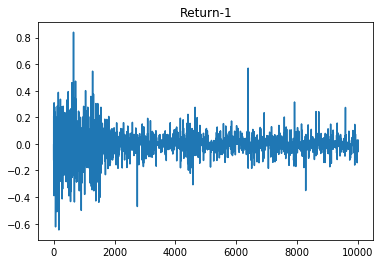

In [50]:
import matplotlib.pyplot as plt
import pandas as pd


x,y = zip(*total_returns_list)
z = [y_i-1 for y_i in y]
z = pd.DataFrame(z)
z = z[z<=25]

plt.plot(x,z)
plt.title('Return-1')
plt.show()

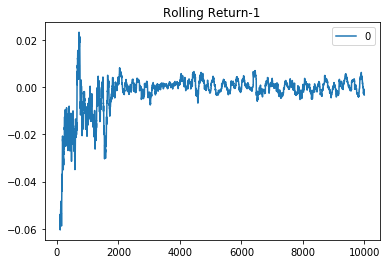

In [51]:
rolling_z = z.rolling(100).mean()
rolling_plot = rolling_z.plot(title='Rolling Return-1')

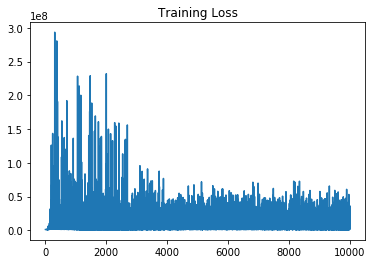

In [52]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

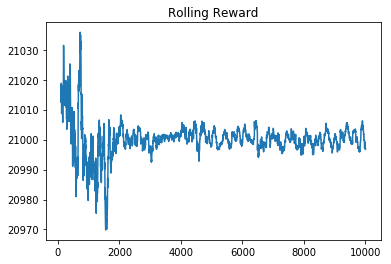

In [53]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
plt.plot(ep[:],reward.rolling(100).mean())
plt.title('Rolling Reward')
plt.show()

Run episode with trained model:

In [54]:
def run_episode(env): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            if done:
                break

    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    
    
    print('Return: {:.5f}'.format(info_log['total_return']))
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(17,4))
    #Plot Prices
    plt.xticks(rotation=90)
    plt.grid(color='k', linestyle='--', linewidth=0.1)
    plt.ylim(min(plt_df.Close)*0.98, max(plt_df.Close)*1.02)
    plt.plot(plt_df.index,plt_df.Close,color='black')
    #Plot Buys
    plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Close,
                color='green',marker='^',s=100,zorder=3)
    #Plot Buys
    plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Close,
                color='red',marker='v',s=100,zorder=3)

    for i, txt in enumerate(plt_df.Trades):
        if txt !=0:
            plt.annotate(txt, (plt_df.index[i], plt_df.Close[i]+0.008*plt_df.Close[i]))
            plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Close[i]-0.015*plt_df.Close[i]))

    plt.show()
    return plt_df

Return: 1.00000


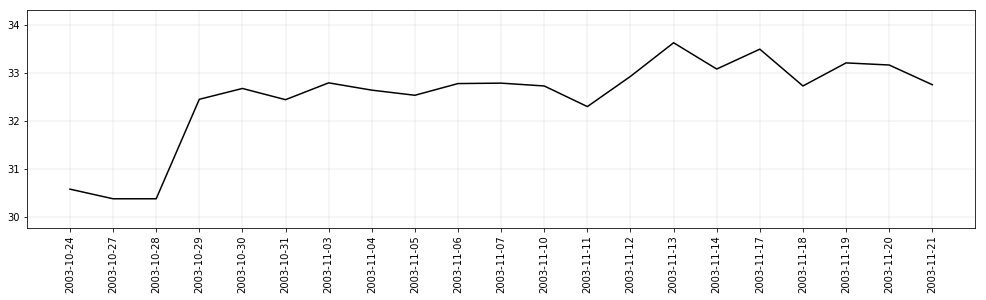

In [59]:
plt_df = run_episode(env)

In [ ]:
plt_df

In [ ]:
plt_df.to_clipboard()

In [ ]:
info_log['total_return']